<font size="6">CRISP-DM-Approach</font>  
 
Please be aware that in my analysis data understanding comes before and after data preparation, as I need to clean variables in order to understand and plot them.

In [84]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')


%matplotlib inline

In [85]:
listings = pd.read_csv('airbnb data Seattle/listings.csv')
reviews = pd.read_csv('airbnb data Seattle/reviews.csv')
calendar = pd.read_csv('airbnb data Seattle/calendar.csv')

In [86]:
cal = calendar.copy()
lis = listings.copy()

# Business Problem

* How expensive is a night in Seattle?
* When should I visit Seattle? (to save money)
* Can I find great places without paying too much money?
* What can I learn about the different districts and their vibes?
* Can I predict the price per listing?

# Data Understanding

In [87]:
listings.head(3)

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  

[3 rows x 92 columns]

In [88]:
listings.last_scraped.max()

'2016-01-04'

In [89]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [90]:
lis.smart_location.value_counts()

Seattle, WA                  3810
West Seattle, WA                2
Seattle , WA                    2
西雅图, WA                         1
Phinney Ridge Seattle, WA       1
Ballard, Seattle, WA            1
seattle, wa                     1
Name: smart_location, dtype: int64

In [91]:
for col in (lis.columns[lis.nunique() == 2]):
    print(col, set(lis[col]))

host_acceptance_rate {nan, '0%', '100%'}
host_is_superhost {nan, 't', 'f'}
host_has_profile_pic {nan, 't', 'f'}
host_identity_verified {nan, 't', 'f'}
state {'wa', 'WA'}
is_location_exact {'t', 'f'}
instant_bookable {'t', 'f'}
require_guest_profile_picture {'t', 'f'}
require_guest_phone_verification {'t', 'f'}


In [92]:
lis.neighbourhood.value_counts()

Capitol Hill          351
Ballard               213
Belltown              204
Minor                 192
Queen Anne            187
                     ... 
Pike Market             2
South Park              2
Roxhill                 1
North College Park      1
Fairmount Park          1
Name: neighbourhood, Length: 81, dtype: int64

In [93]:
lis.neighbourhood_cleansed.value_counts()

Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
Pinehurst              4
South Beacon Hill      4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64

In [94]:
lis.neighbourhood_group_cleansed.value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

In [95]:
lis.state.value_counts()

WA    3817
wa       1
Name: state, dtype: int64

In [96]:
lis.host_location.value_counts()

Seattle, Washington, United States          3259
US                                           246
Spokane, Washington, United States            41
Kent, Washington, United States               34
Los Angeles, California, United States        13
                                            ... 
White Pine, Tennessee, United States           1
Snohomish, Washington, United States           1
Burien, Washington, United States              1
Camano Island                                  1
West New York, New Jersey, United States       1
Name: host_location, Length: 120, dtype: int64

# Data Preparation

* Check if target variable has missing values

In [97]:
lis.price.isna().any()

False

## Convert columns to float or date

### Convert price to float

In [98]:
def price_to_float(df, cols):
    """
    Transforms object columns, which contain $ sign into float
    Returns new df
    """
    for col in cols:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('$','').str.replace(',','').astype(float)
    return df

price_cols = ['price', 'weekly_price', 'monthly_price', 'cleaning_fee', 'extra_people','security_deposit']
lis = price_to_float(lis, price_cols)
cal = price_to_float(cal, ['price'])

In [99]:
lis[price_cols]

price  weekly_price  monthly_price  cleaning_fee  extra_people  \
0      85.0           NaN            NaN           NaN           5.0   
1     150.0        1000.0         3000.0          40.0           0.0   
2     975.0           NaN            NaN         300.0          25.0   
3     100.0         650.0         2300.0           NaN           0.0   
4     450.0           NaN            NaN         125.0          15.0   
...     ...           ...            ...           ...           ...   
3813  359.0           NaN            NaN         230.0           0.0   
3814   79.0           NaN            NaN          50.0          25.0   
3815   93.0         450.0            NaN          35.0          20.0   
3816   99.0           NaN            NaN          45.0           0.0   
3817   87.0           NaN            NaN           NaN           0.0   

      security_deposit  
0                  NaN  
1                100.0  
2               1000.0  
3                  NaN  
4                700.0  
...                ...  
3813               NaN  
3814             500.0  
3815             250.0  
3816             300.0  
3817               NaN  

[3818 rows x 6 columns]

### Convert rates and % to float

In [100]:
lis['host_response_rate'] = listings.host_response_rate.str.replace('%','').astype(float)/100

### Convert str dates to time

In [101]:
def str_to_date(df, cols):
    """
    Transforms str columns into datetime (if applicalbe)
    return new df
    """
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df
cal = str_to_date(cal, ['date'])
lis = str_to_date(lis, ['host_since', 'last_review'])


* Drop columns, which do not add any additional informations for regressions or analysis
** e.g. street, zip code, neighbourhood & neighbourhood cleansed as we can use neighbourhood_grouped_cleansed

In [102]:
def drop_columns(df, cols):
    """
    return dataframe, where provided columns are dropped
    """
    for col in cols:
        if col in df.columns:
            df = df.drop(columns = col)
    return df


In [103]:
#only NA license
lis = drop_columns(lis, ['license'])

#all urls
url = lis.columns[lis.columns.str.contains('url')]
lis = drop_columns(lis, url)

#all available columns
avai = lis.columns[lis.columns.str.contains('availa')]
lis = drop_columns(lis, avai)

#host specific information, which is irrelevant
host = ['host_id', 'host_name','host_acceptance_rate', 'host_location', 'host_neighbourhood', 'host_verifications']
lis = drop_columns(lis, host)

#location information, which is covered by neighbourhood_grouped_cleansed
loc_info = ['neighbourhood', 'neighbourhood_cleansed', 'street', 'zipcode', 'state', 'city']
lis = drop_columns(lis, loc_info)

#weekly and monthly price as I am only interested in price and it is slghtly redundant
lis = drop_columns(lis, ['weekly_price', 'monthly_price'])

#technical info
lis = drop_columns(lis,  ['calendar_updated', 'first_review'])

lis = drop_columns(lis,  ['smart_location', 'experiences_offered', 'name'])


#drop dates for prediction. Does not work for linaer regression or logistoc regression
lis = drop_columns(lis,  ['last_review', 'host_since'])

* Convert all true false columns into binary columns

In [104]:
def convert_True_False(df):
    """
    Convert columns with true and false into Binary columns
    Reason: No need to encode later
    """
    true_false_cols = []
    for col in df.columns[df.dtypes=='object']:
        if all(elem in df[col].unique() for elem in ['f', 't']):
            df[col] = df[col].map({'f': False, 't':True})
            df[col] = df[col].astype('bool')
            true_false_cols.append(col)
    return df, true_false_cols

In [105]:
lis, true_false_cols = convert_True_False(lis)

Drop all columns, which contain only 1 unique value. They do not add any additional information and drop columns, which have more than 30% of the data row unique values --> No time to do any grouping or classification

In [106]:
def drop_col_no_info(df):
    """
    Drop columns, which contain only one unique value
    """
    df = df.drop(columns = df.columns[df.nunique()==1])
    #df = df.drop(columns = lis.columns[lis.nunique()==len(lis)])
    #df = df.drop(columns = lis.columns[(lis.dtypes=='object') & ((lis.nunique()/len(lis)) > 0.3)])
    return df

In [107]:
lis = drop_col_no_info(lis)

In [108]:
lis[lis.columns[lis.dtypes=='object']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   summary                       3641 non-null   object
 1   space                         3249 non-null   object
 2   description                   3818 non-null   object
 3   neighborhood_overview         2786 non-null   object
 4   notes                         2212 non-null   object
 5   transit                       2884 non-null   object
 6   host_about                    2959 non-null   object
 7   host_response_time            3295 non-null   object
 8   neighbourhood_group_cleansed  3818 non-null   object
 9   property_type                 3817 non-null   object
 10  room_type                     3818 non-null   object
 11  bed_type                      3818 non-null   object
 12  amenities                     3818 non-null   object
 13  cancellation_polic

In [109]:
for col in lis.columns[lis.dtypes=='object']:
    print(col, ': \n', lis[col].value_counts())

summary : 
 This is a modern fully-furnished studio apartment in a brand new building on Capitol Hill. At Roy Street Commons you can enjoy your complete privacy and mingle with our other guests in our common areas, when it suits you.                                                         15
Our space is a mix of a hostel and a home. We are a group of long-term residents & subletors who welcome short term guests. This is the house to meet folks whether you are moving to town or traveling through. The house offers quiet and social spaces.                            11
Built, run and supported by Seattle tech and start up veterans, GrokHome's focus is to create a supportive environment for smart people working on interesting projects, start ups and more. This listing is an upper bunk, in a 4-person shared room.                                 8
Built, run and supported by Seattle tech and start up veterans, GrokHome's focus is to create a supportive environment for smart people working o

In [110]:
lis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   summary                           3641 non-null   object 
 2   space                             3249 non-null   object 
 3   description                       3818 non-null   object 
 4   neighborhood_overview             2786 non-null   object 
 5   notes                             2212 non-null   object 
 6   transit                           2884 non-null   object 
 7   host_about                        2959 non-null   object 
 8   host_response_time                3295 non-null   object 
 9   host_response_rate                3295 non-null   float64
 10  host_is_superhost                 3818 non-null   bool   
 11  host_listings_count               3816 non-null   float64
 12  host_t

## Clean numerical columns

Impute mean value for missing numerical values
Do not do that for price and binary variables

In [111]:
def clean_numerical_col(df, exclude):
    """
    Impute mean value for missing numerical values
    """
    num_col = df.drop(columns = exclude).select_dtypes(include = ['float', 'int']).columns
    print(num_col)
    fill_mean = lambda col: col.fillna(col.mean())
    df[num_col] = df[num_col].apply(fill_mean, axis = 0)
    return df

In [112]:
lis = clean_numerical_col(lis, true_false_cols + ['price'])
lis.info()

Index(['host_response_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'bathrooms',
       'bedrooms', 'beds', 'square_feet', 'security_deposit', 'cleaning_fee',
       'extra_people', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   summary                           3641 non-null   object 
 2   space                             3249 non-null   object 
 3   description                       3818 non-null   object 
 4   neighborhood_overview             

# Data understanding after Data Preparation

## histogram of prices

**Findings**  


Air BnB prices in Seattle vary between 20 Dollar and 1000 Dollar per night!  

Most common are prices around 100$ per night

min  20.0 max  1000.0
median 100.0


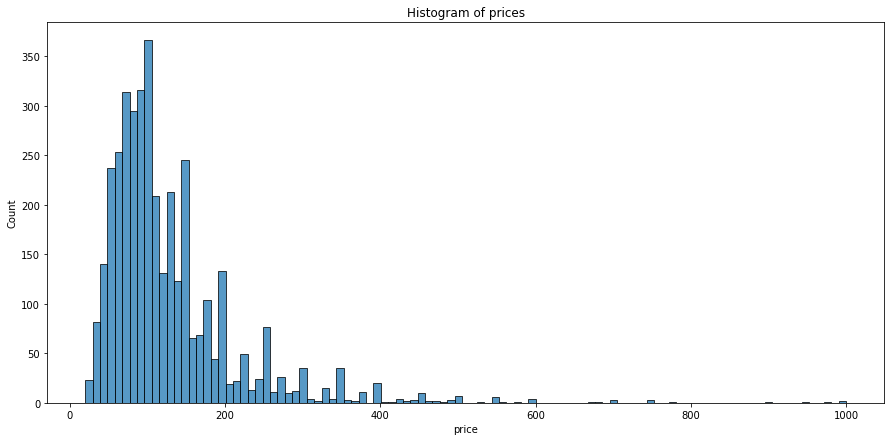

In [113]:
fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
sns.histplot(x="price", data = lis)
plt.title('Histogram of prices')
plt.savefig('pictures/Price histogram')
print('min ',lis.price.min(),'max ',lis.price.max())
print('median', lis.price.median())

## Boxplot of prices

We have many outliers in the data. I think it will be very difficult to catch them properly. Hence I will try to remove them

-37.5 262.5
3818
3572
% of dropped rows due to outlier cleaning: 0.0644316396018858


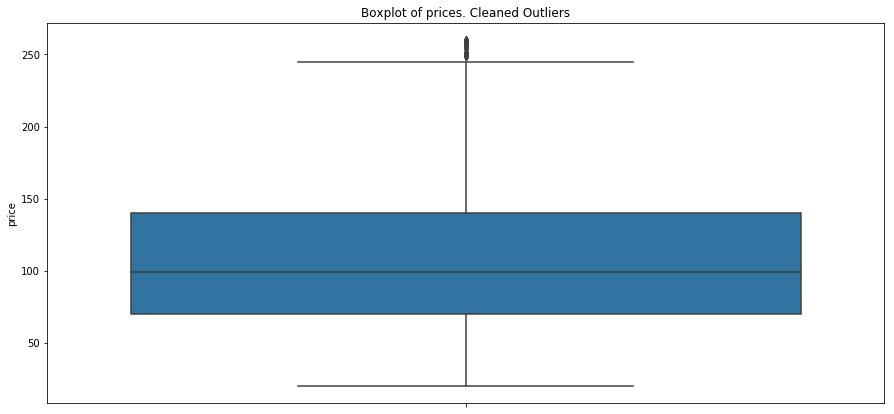

In [114]:
Q1 = lis['price'].quantile(0.25)
Q3 = lis['price'].quantile(0.75)
IQR = Q3-Q1
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR
print(Lower_Whisker, Upper_Whisker)

fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
sns.boxplot(y="price", data=lis[lis['price']< Upper_Whisker])#
plt.xticks(rotation=45)
plt.title('Boxplot of prices. Cleaned Outliers')
plt.savefig('pictures/Price boxplot')

lis_drop_outlier = lis[lis['price']< Upper_Whisker]
print(len(lis))
print(len(lis_drop_outlier))
print('% of dropped rows due to outlier cleaning:', 1 -(len(lis_drop_outlier)/len(lis)))

In [115]:
lis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   summary                           3641 non-null   object 
 2   space                             3249 non-null   object 
 3   description                       3818 non-null   object 
 4   neighborhood_overview             2786 non-null   object 
 5   notes                             2212 non-null   object 
 6   transit                           2884 non-null   object 
 7   host_about                        2959 non-null   object 
 8   host_response_time                3295 non-null   object 
 9   host_response_rate                3818 non-null   float64
 10  host_is_superhost                 3818 non-null   bool   
 11  host_listings_count               3818 non-null   float64
 12  host_t

## Boxplots and histograms of price per binary variable

**Findings**
Some informations in the dataset are binary. Is there a binary feature, which splits expensive vs. cheap apartmets? Unfrortunately teh answer is no
* **host is superhost** Apartments from superhosts are not generally more expensive. Both types have a median price of around 100 Dollar. But superhost listings have more expensive outliers than non-superhost listings. This could be due to more modern, luxurious apartments or due to better areas  
    
* **require guest profile picture and phone verification** Interestingly listings, which require a profile picture or a phone verification tend to be more expensive. It makes sens that landlords want to have more safety for more expensive accomodations and furniture

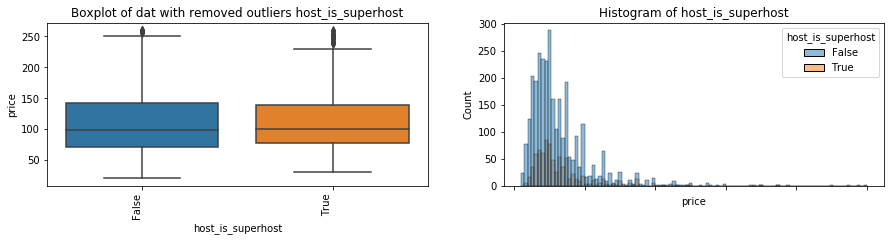

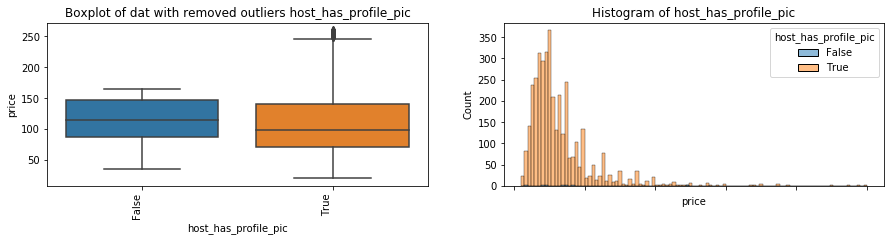

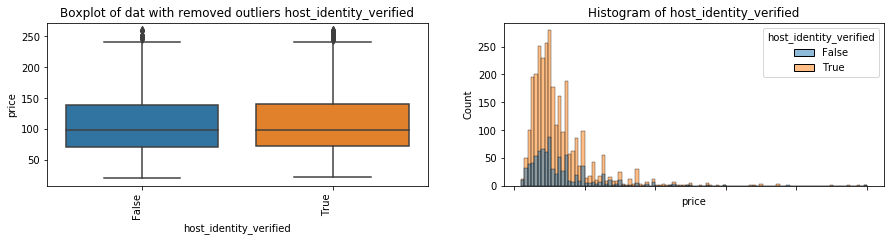

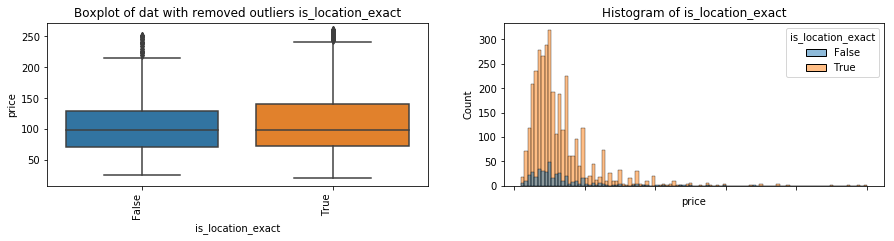

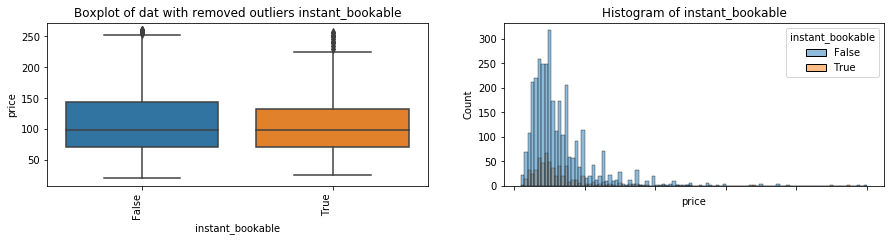

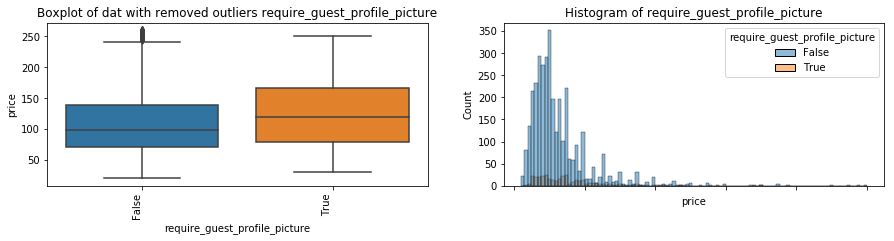

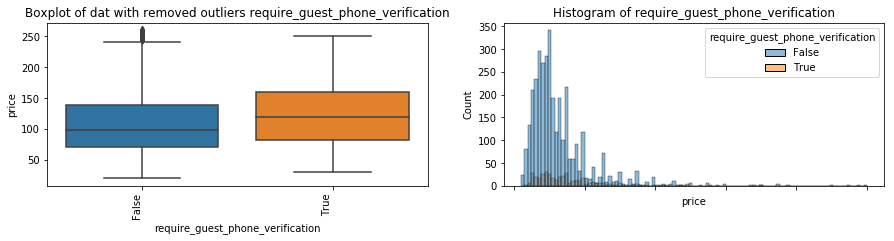

In [116]:
for col in true_false_cols:
    fig, ax = plt.subplots(1,2, figsize = (15,3))
    g1 = sns.boxplot(ax = ax[0], x=col, y="price", data=lis_drop_outlier)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90, horizontalalignment='right')
    g1.set_title('Boxplot of dat with removed outliers ' + col)
    g2 = sns.histplot(ax = ax[1], x="price", data = lis, hue = col)
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90, horizontalalignment='right')
    g2.set_title('Histogram of ' + col) 

## Correlation of numerical variables

**Some data correlates and can be dropped**

* From all scores columns, keep only the ones, which have correl < 0.5 to the overall review_scores_rating --> Drop all except review_scores_rating and review_scores_location

In [118]:
corr = lis[lis.columns[lis.columns.str.contains('scores')]].corr()

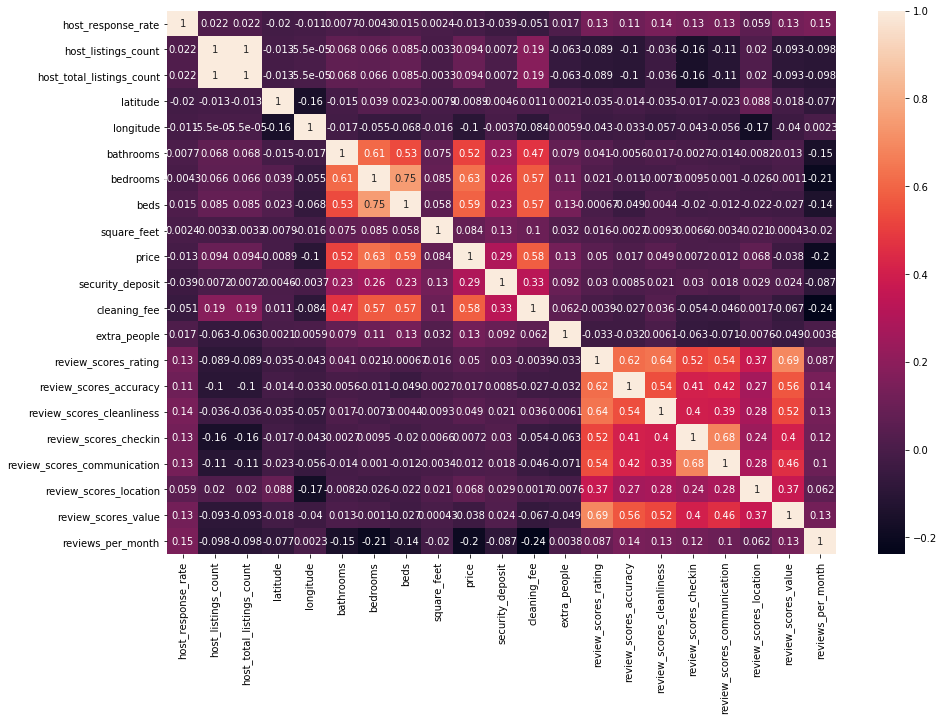

In [119]:
#col = list(lis.columns[lis.columns.str.contains('scores')])
#col.extend(['price'])
fig = plt.subplots(1,1, figsize = (15,10))
col = lis.select_dtypes(include = ['float', 'int']).columns
sns.heatmap(data = lis[col].corr(), annot = True);

Drop correlating columns with no additional information

In [120]:
corr_col = corr.columns[corr.loc['review_scores_rating']>0.5].drop('review_scores_rating')
print(corr_col)
lis = drop_columns(lis, corr_col)
lis = drop_columns(lis, ['security_deposit','beds', 'host_total_listings_count'])

Index(['review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_value'],
      dtype='object')


## Scatterplots between numerical variables and price

**Findings**
I was hoping to find a variable, which has a linear or even exponential relationship with the price. But there are too many other factors, which might play a role. The is one excitin outcome though: The rating does not correlate with the price. What does that mean? It means that you can find a real jewel with amazing rating but an affordable price.
* **host listing counts**. There seems to be a min. boundary relation between host listings counts and price. The more listings a host has, the higher is the cheapest available price
* **bedrooms**. Similar behaviour as above
* **people** Similar behaviour as above
* **cleaning fee** See above. Makes sense - furniture, which requires special care or bigger places have higher cleaning fees and are in general more expensive
* **review score rating** great news for all customers! A higher review score does not mean a higher price. There seems to be absolutely no correlation and you can probably find hidden gems there!

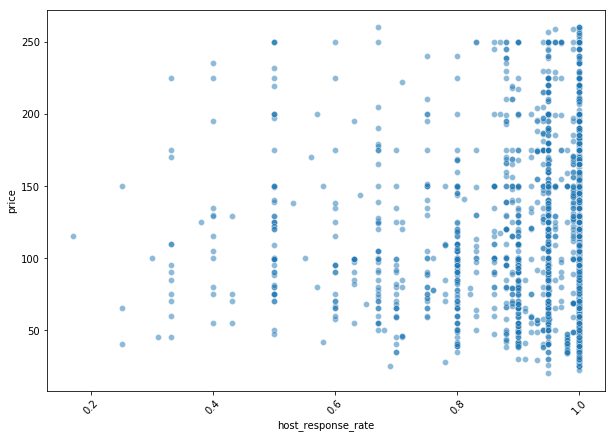

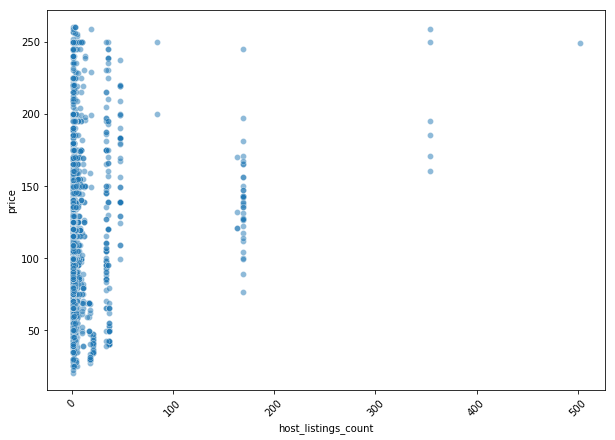

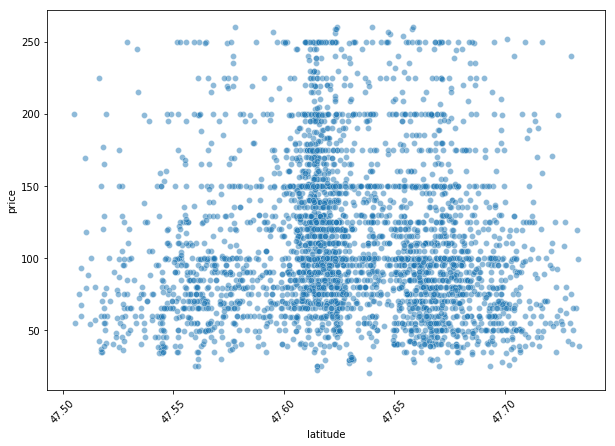

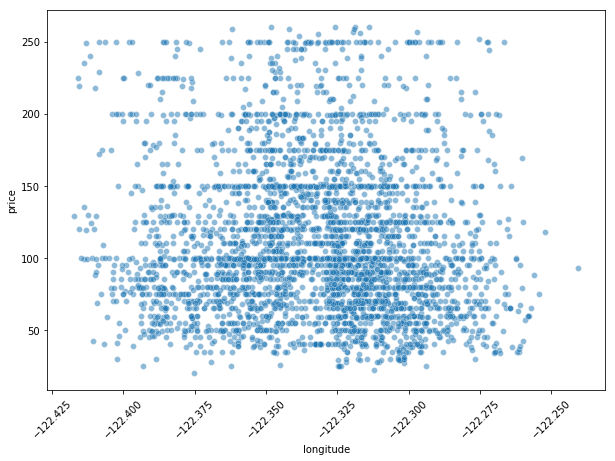

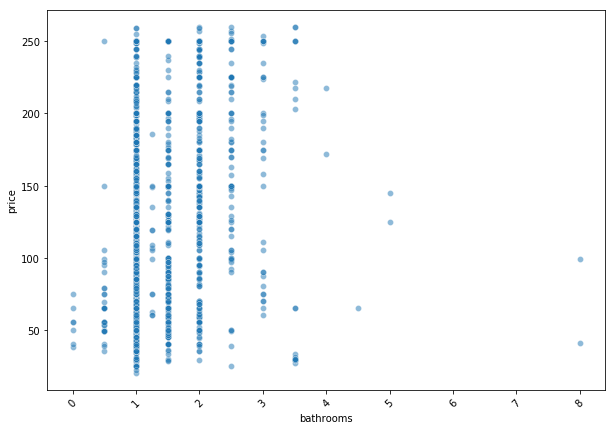

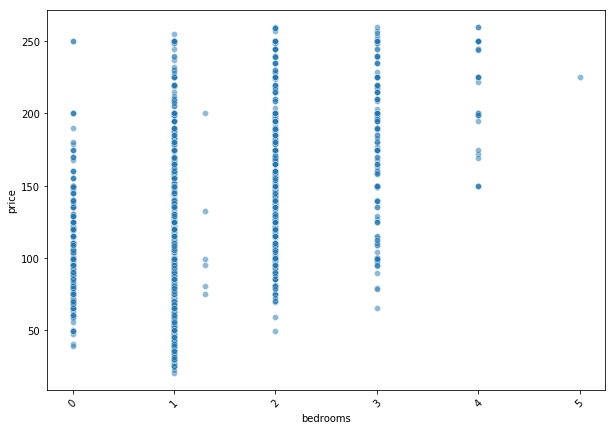

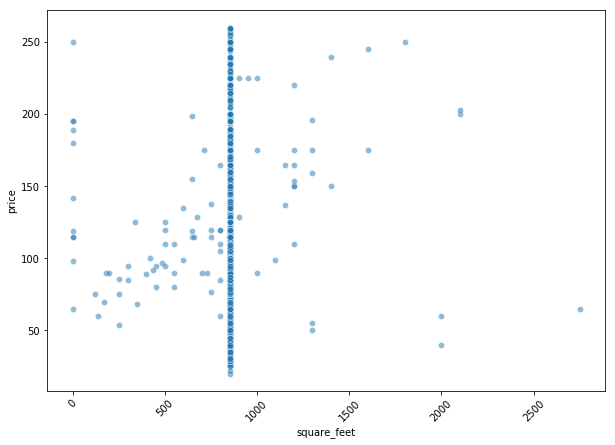

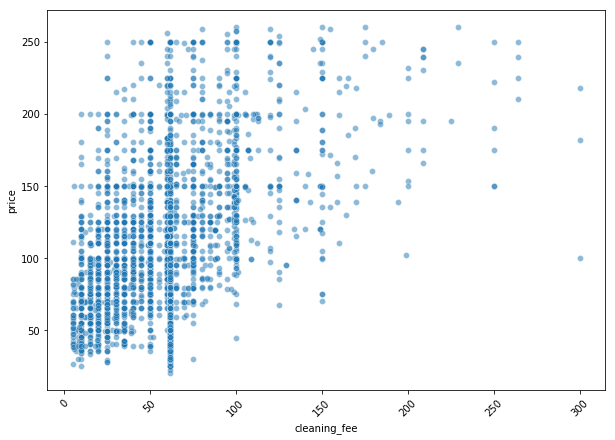

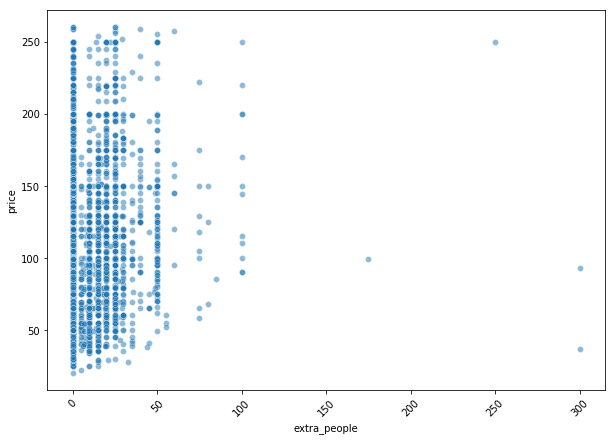

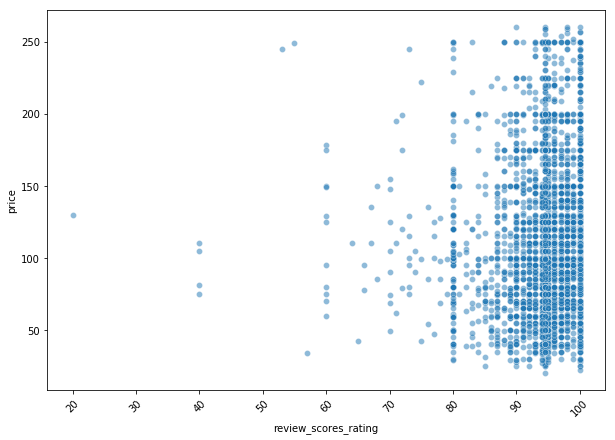

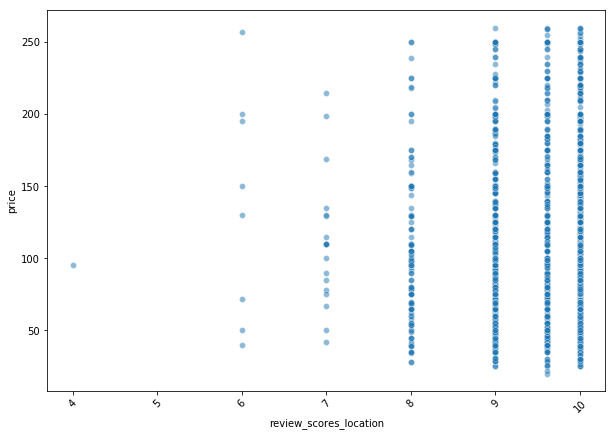

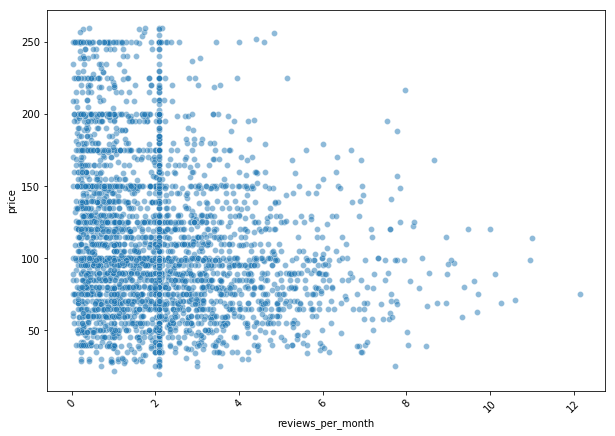

In [121]:
num_col = lis.drop(columns = true_false_cols + ['price']).select_dtypes(include = ['float', 'int']).columns
for col in num_col:
    fig, (ax1) = plt.subplots(1,1, figsize = (10,7))
    sns.scatterplot(x=col, y="price", data=lis_drop_outlier, alpha = 0.5)
    plt.xticks(rotation=45)
    plt.savefig('pictures/scatter_' + col)
#sns.pairplot(data = lis[num_col])

## Plot price development over time

## Price per day all data history

**Analysis over time**
* Does the price change over time?
* When is the cheapest time to visit Seattle?

**Answer** 
* First of all, the summer is more expensive than the winter with a peak between July and August
* Even though I have only data between January 2016 and January 2017 it seems like prices are overall strongly increasing



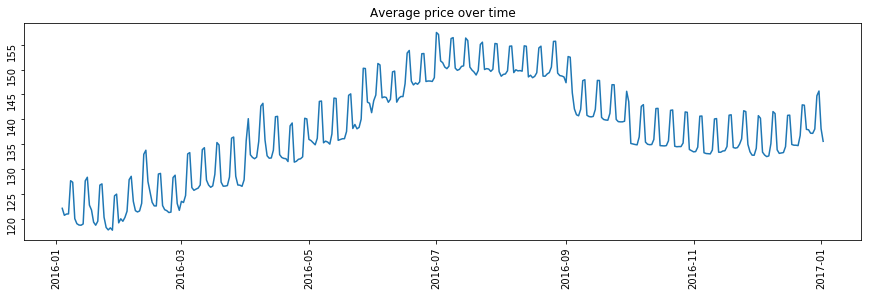

In [122]:
cal[cal.available == 't'].groupby(['date'], as_index= False)['price'].mean()
fig, ax1 = plt.subplots(1,1, figsize = (15,4))

ax1.plot(cal[cal.available == 't'].groupby(['date'], as_index= False)['price'].mean().date, cal[cal.available == 't'].groupby(['date'], as_index= False)['price'].mean().price)
ax1.tick_params(labelrotation=90)
plt.title('Average price over time');
plt.savefig('pictures/Average Price over time')

In [123]:
cal['day_of_week'] = cal['date'].dt.weekday
cal['day_name'] = cal['date'].dt.day_name()

cal['month'] = cal['date'].dt.month

## Plot amount of listings over time

**Analysis: What is the availability development of AirBnb offers in Seattle over the time?**

* Available listings seem to be increasing as well with a drop in Aprl 2016 and July 2016.

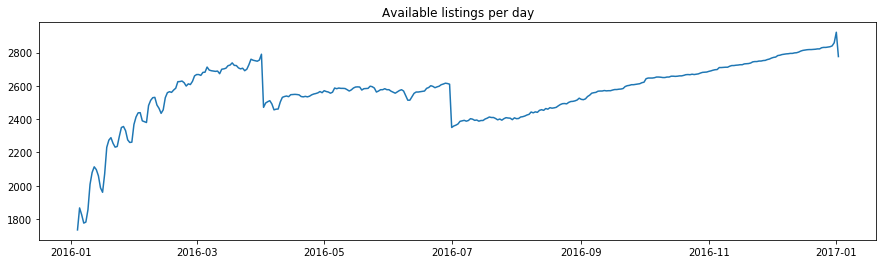

In [124]:
fig, ax1 = plt.subplots(1,1, figsize = (15,4))
count_list = cal[cal.available == 't'].groupby(['date'], as_index = False)['listing_id'].count()
plt.plot(count_list.date, count_list.listing_id)
plt.title('Available listings per day');
plt.savefig('pictures/Available listings per day')

## Plot cost per weekday vs. listings per weekday

**Analysis price per weekday**
* If you want to come during summer, there are still great price drops during weekdays. Come between Sunday and Wednesday and you will save approx. 8 Dollar per night

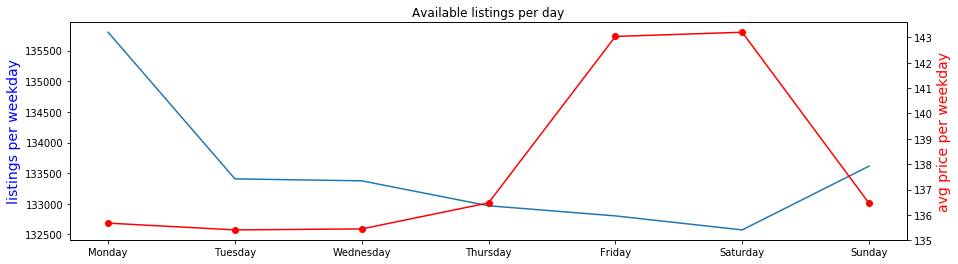

In [125]:
fig, ax1 = plt.subplots(1,1, figsize = (15,4))
count_list = cal[cal.available == 't'].groupby(['day_of_week','day_name'], as_index = False).agg({'listing_id':'count', 'price':'mean'})
ax1.plot(count_list.day_name, count_list.listing_id)
ax1.set_ylabel("listings per weekday",color="blue",fontsize=14)
ax2 = ax1.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(count_list.day_name, count_list.price,color="red",marker="o")
ax2.set_ylabel("avg price per weekday",color="red",fontsize=14)
#plt.plot(count_list.day_name, count_list.price)
plt.title('Available listings per day');
plt.savefig('pictures/Average Price per weekday')

# NLP analysis

## find describing adjectives of listing to create better features for prediction

### Tokenize listing description

In [126]:
adjective_tags = ["JJ", "JJR", "JJS"]

In [127]:
def tokenize_and_extract_close(df, col, target, tags, word_type):
    """
    Function returns list of describing words close to a target word. E.g. adjectives, close to the noun 'apartment'
    
    Function input: dataframe with column to tocenize word type, word_type, NLP tags for word type
    Function output: dataframe containing all adjectives from col, which are 9 words after or before the target noun
    
    Function does not change the input dataframe
    """
    final = []
    tokenized_sents = [word_tokenize(i) for i in df[col]]
    
    for sentence in tokenized_sents:
        close = []
        words = [word[0].lower() for word in nltk.pos_tag(sentence) if word[1] in tags]
        sentence = [word.lower() for word in sentence]
   
        for target_noun in synonyms:
            if target_noun in sentence:
                indexes = [i for i,x in enumerate(sentence) if x == target_noun]
                for ind in indexes:
                    #Get all words, which are up to 9 words away from target nount
                    temp = sentence[ind-min(9,ind) :ind +9] 
                    temp = [w.lower() for w in temp]
                    close.extend([word for word in words if word in temp])
        final.extend(set(close))
        if '*' in final:
            final.remove('*')
    final = pd.DataFrame({word_type:final})
    return(final)

In [128]:
synonyms = ['apartment', 'apartments','house', 'houses', 'suite', 'cabin', 'cabins', 'bungalow', 'space', 'home', 'camper', 'cottage', 'farmhouse', 'room', 'studio', 'bedroom', 'kitchen', 'guesthouse']
final_adj = tokenize_and_extract_close(lis, 'description', synonyms, adjective_tags, 'adjective')

In [129]:
final_adj = final_adj.adjective.value_counts().head(20)
final_adj = pd.DataFrame({'adjective':final_adj.index, 'adj_count':final_adj})
final_adj

adjective  adj_count
private          private       1057
full                full        936
large              large        652
queen              queen        641
comfortable  comfortable        570
quiet              quiet        491
spacious        spacious        470
available      available        465
great              great        426
new                  new        385
own                  own        369
modern            modern        368
beautiful      beautiful        363
main                main        328
small              small        327
open                open        313
entire            entire        300
clean              clean        295
free                free        294
other              other        272

### Plot average price per describing adjective

Goal: Can I find adjectives, which make good price predictors?  
Idea: Plot average price per adjective to find distinctive adjectives and create adjective dummy variables

In [132]:
# Get avarage price per adjective (if adjective is in description)
col_names = []
final_adj['avg_price'] = 0
for adj in final_adj['adjective']:
    name = 'aprtmnt_adj_' + adj
    col_names.append(name)
    lis[name] = lis.description.str.contains(adj)
    final_adj.loc[adj,'avg_price'] = lis[lis[name] == True].price.mean()


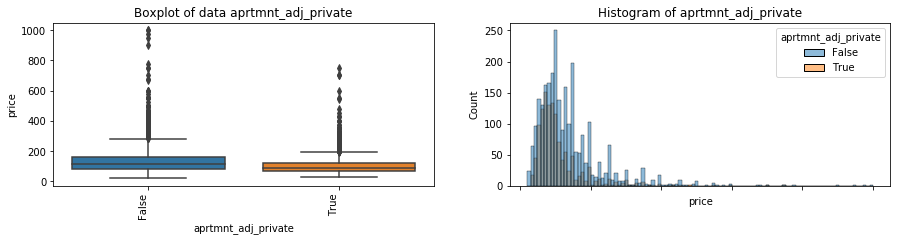

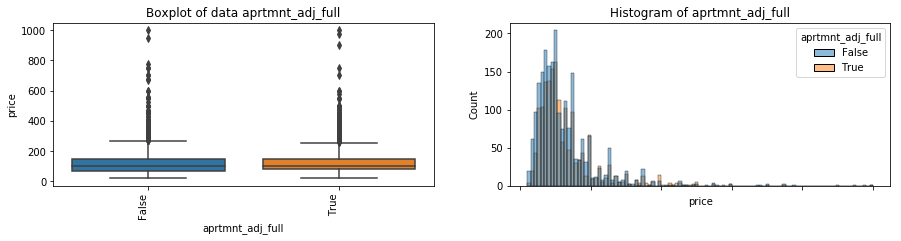

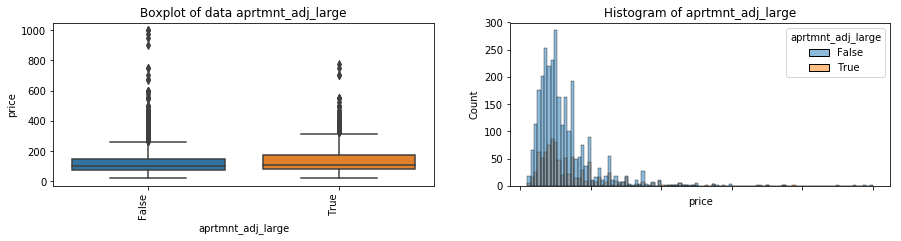

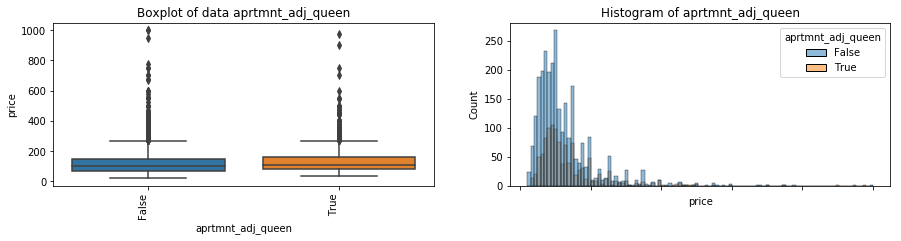

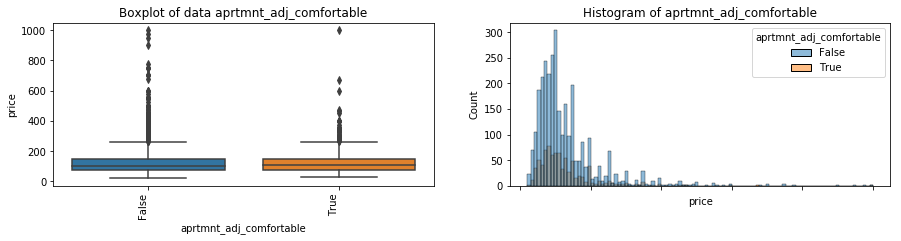

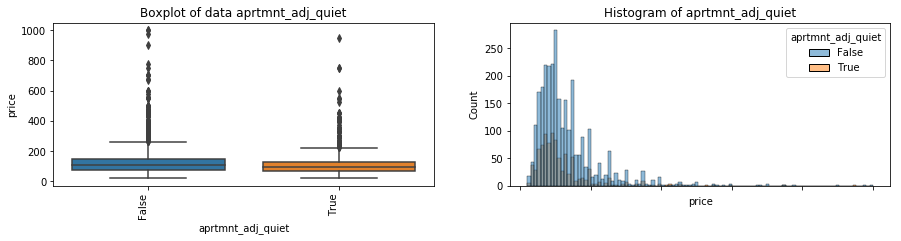

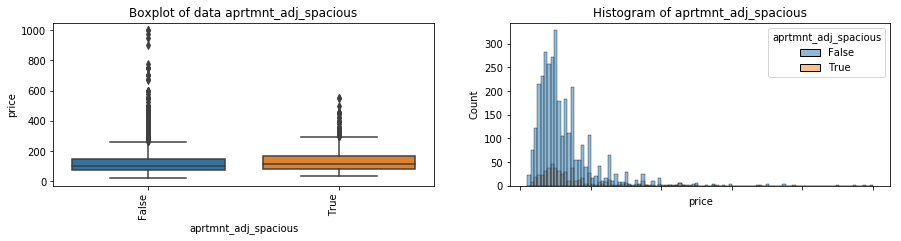

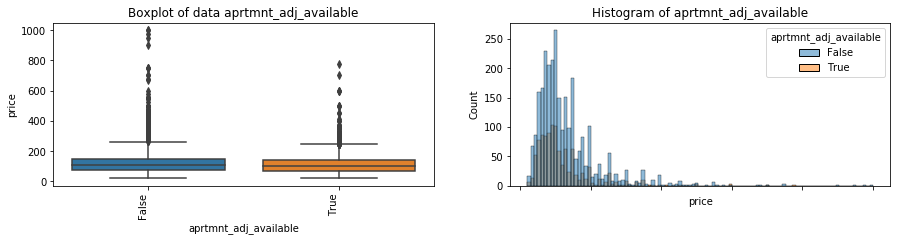

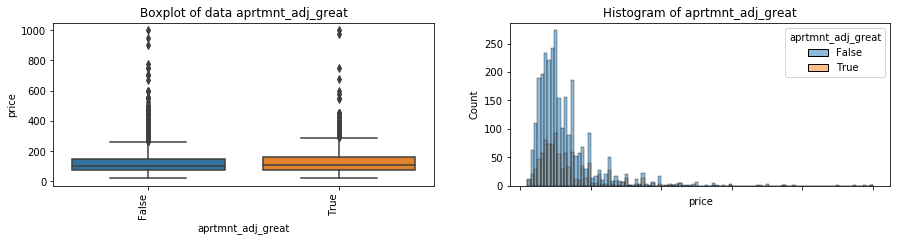

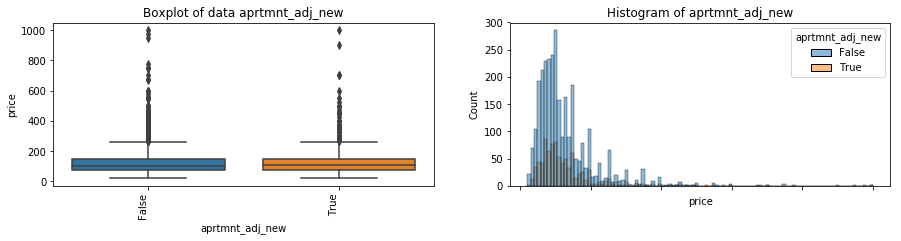

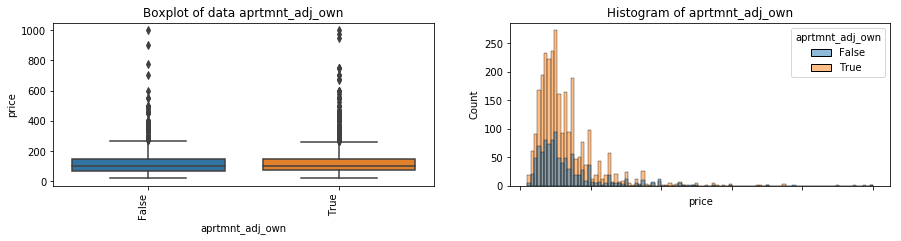

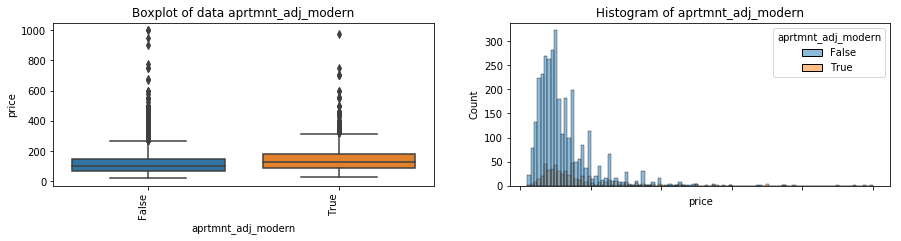

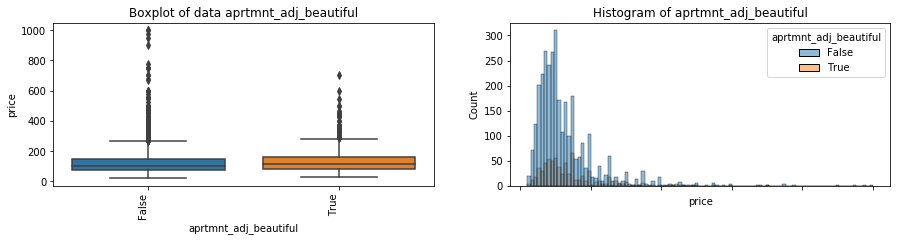

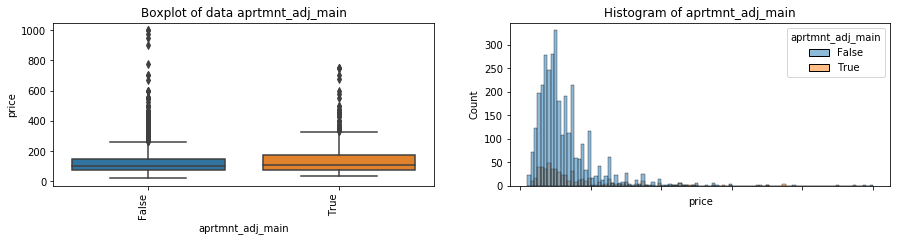

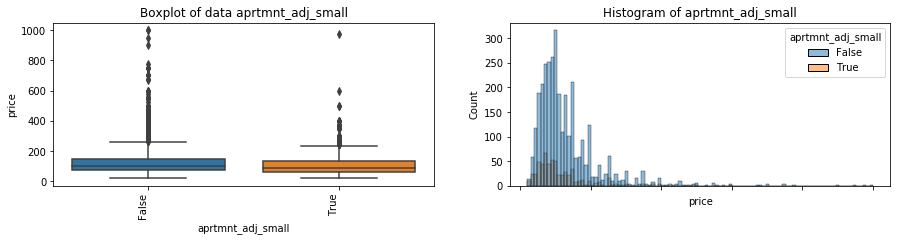

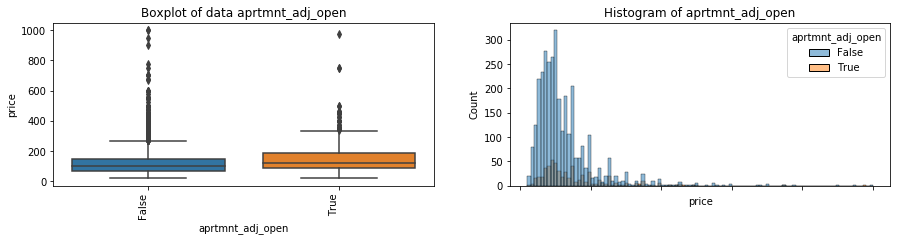

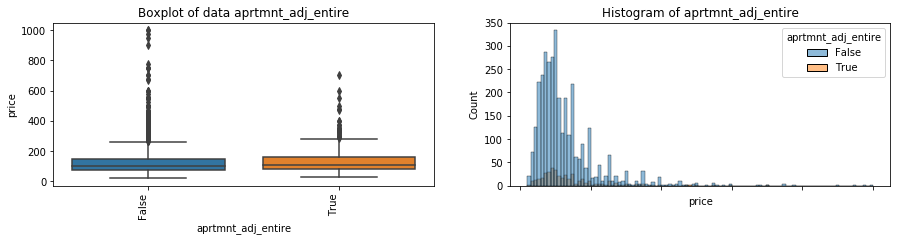

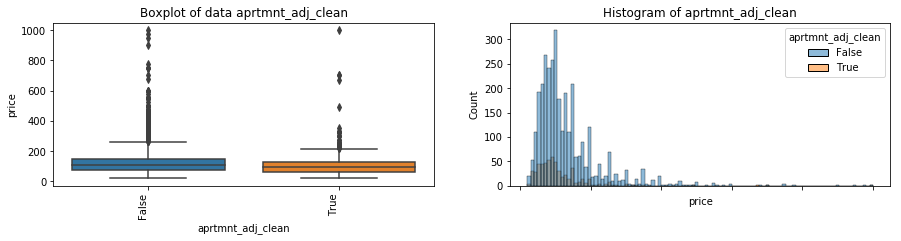

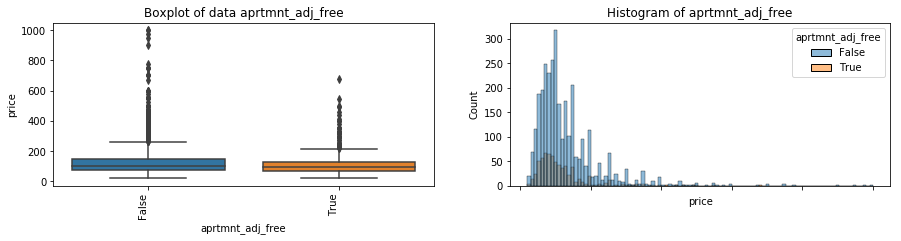

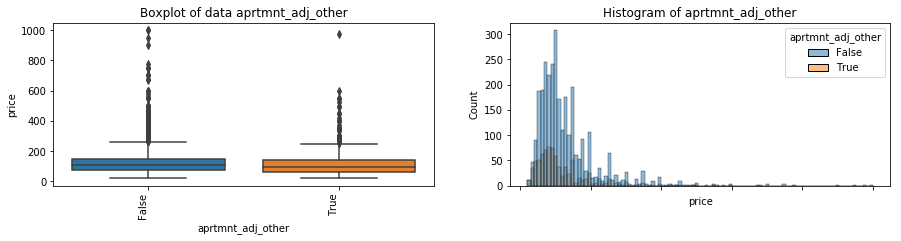

In [133]:
for col in col_names:
    fig, ax = plt.subplots(1,2, figsize = (15,3))
    g1 = sns.boxplot(ax = ax[0], x=col, y="price", data=lis)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90, horizontalalignment='right')
    g1.set_title('Boxplot of data ' + col)
    g2 = sns.histplot(ax = ax[1], x="price", data = lis, hue = col)
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90, horizontalalignment='right')
    g2.set_title('Histogram of ' + col)

## Find describing adjectives of location. This is not important for the prediction, but interesting in order to understand the vibe per neighborhood

**Can I learn anything about Seattle's neighbourhoods without knowing the city?**
Yes! Because Python and its libraries are amazing! I have tried natural language processing for the very first time and I am already able to describe the different neighborhoods. 

What did I do? I extracted all adjectives of each neighbourhood description and stored it in a dataframe (adj_df).  

I looked for the top 20 adjectives and nouns and calculated the average amount of mentions of each noun and adjective per neighbourhood.
That way I make sure, that I do not overcount nouns and adjectives in neighbourhoods, which have many listings.
Be aware: I could have also reandomly decided for adjectives and nouns, which I think are interesting, but I wanted to take those, which appear most overall.
* A quiet neighbourhood? Go to **Magnolia or Delridge**
* Local restaurants and bars? Go to **University District** or **Ballard**
* Residential Area? **Beacon Hill, Delridge**
* Most Popular? **University District**
* Walkable? **Lake city, Ballard**
* Vibrant? **University District**
* Diverse? **University District, Rainler Valley**
* Famous Sightseeing? **Queen Anne**



Find list of adjectives in neighborhood_overview column

### Tokenize neighbourhood description

Create list, which contains all adjectives from all neighbourhood descriptions (which NLP identifies) to find the most common adjectives

In [135]:
def tokenize_and_extract(df, col, tags, word_type):
    """
    Function input: dataframe with column to tocenize word type, word_type, NLP tags for word type
    Function output: dataframe containing all adjectives from col
    Function does not change the input dataframe
    """
    final = []
    tokenized_sents = [word_tokenize(i) for i in df[col].fillna('')]
    df['tokenized_' + col] = tokenized_sents
    for sentence in tokenized_sents:
        close = []
        temp = [word[0].lower() for word in nltk.pos_tag(sentence) if word[1] in tags]
        sentence = [word.lower() for word in sentence]
        final.extend(temp)
        if '*' in final:
            final.remove('*')
    
    final = pd.DataFrame({word_type:final})
    return(final)

In [136]:
adj_df = tokenize_and_extract(lis, 'neighborhood_overview', adjective_tags, 'adjective')

In [137]:
adj_df.value_counts().head(20)

adjective  
great          821
quiet          521
many           511
best           394
easy           368
local          339
few            305
short          293
downtown       270
other          258
beautiful      247
more           243
residential    226
close          210
several        165
safe           164
popular        163
public         158
amazing        149
walkable       147
dtype: int64

Drop not important or unclear adjectives

In [139]:
top_adj_loc = adj_df[~(adj_df.adjective.isin(['great','many', 'best', 'few', 'other', 'more', 'several', 'right', 'good', 'most', 'less']))]['adjective'].value_counts().head(20)
top_adj_loc.head()

quiet       521
easy        368
local       339
short       293
downtown    270
Name: adjective, dtype: int64

### Create dataframe with mean amount of mentions per adjective

In [140]:
def avg_mentions_per_type(df, col, top_words_df, word_type):
    """
    Function returns data frame with average amount of mentions per word per district.
    Input: col = description column to look for adjectives or nouns
           top_words_df = top adjectives or nouns
           word_type = adjective or noun type
    """
    
    location_final = pd.DataFrame({word_type: top_words_df.index.tolist()})
    for loc in list(df['neighbourhood_group_cleansed'].fillna('').unique()):
        location_final[loc] =0

    for name in list(df['neighbourhood_group_cleansed'].fillna('').unique()):
        for word in location_final[word_type]:
            location_final[name].loc[location_final[word_type] == word] = df[df['neighbourhood_group_cleansed'] == name][col].str.contains(word).mean()
    
    return location_final

location_final = avg_mentions_per_type(lis, 'neighborhood_overview', top_adj_loc, 'adjective') 

In [141]:
location_final.head()

adjective  Queen Anne   Ballard  Other neighborhoods   Cascade  \
0     quiet    0.140845  0.145251             0.186386  0.178571   
1      easy    0.136150  0.100559             0.103728  0.232143   
2     local    0.056338  0.150838             0.103728  0.071429   
3     short    0.084507  0.111732             0.115073  0.071429   
4  downtown    0.422535  0.329609             0.277147  0.303571   

   Central Area  University District  Downtown  Magnolia  West Seattle  \
0      0.228261             0.146067  0.034985  0.355556      0.253333   
1      0.141304             0.168539  0.046647  0.066667      0.113333   
2      0.159420             0.202247  0.049563  0.044444      0.126667   
3      0.108696             0.056180  0.061224  0.044444      0.093333   
4      0.304348             0.202247  0.332362  0.422222      0.320000   

   Interbay  Beacon Hill  Rainier Valley  Delridge  Seward Park  Northgate  \
0       0.1     0.146341        0.178862  0.328125     0.236842   0.293103   
1       0.0     0.146341        0.113821  0.015625     0.131579   0.224138   
2       0.0     0.134146        0.154472  0.078125     0.052632   0.034483   
3       0.2     0.085366        0.211382  0.062500     0.289474   0.034483   
4       0.3     0.414634        0.268293  0.453125     0.184211   0.379310   

   Capitol Hill  Lake City  
0      0.166667   0.212766  
1      0.106061   0.170213  
2      0.161616   0.148936  
3      0.063131   0.021277  
4      0.292929   0.191489

Transform dataframe for easier plotting in seaborn

In [142]:
district_melt = pd.melt(location_final, id_vars=['adjective'], value_vars=list(lis.neighbourhood_group_cleansed.unique()))
district_melt.head()

adjective    variable     value
0     quiet  Queen Anne  0.140845
1      easy  Queen Anne  0.136150
2     local  Queen Anne  0.056338
3     short  Queen Anne  0.084507
4  downtown  Queen Anne  0.422535

### Plot mean amount of mentions per adjective (Each plot is one neighborhood)

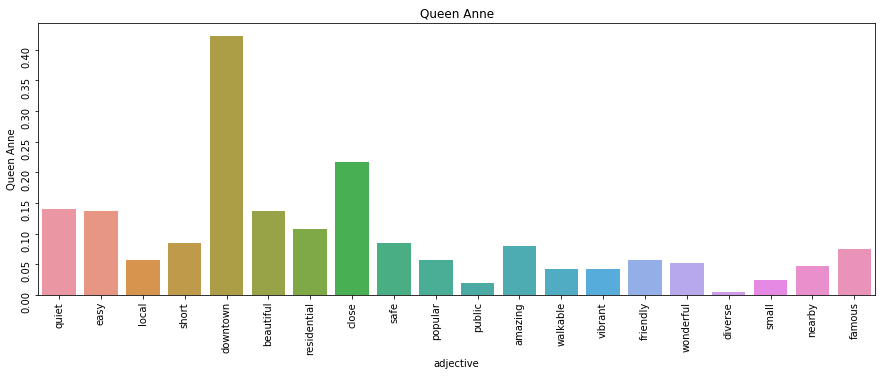

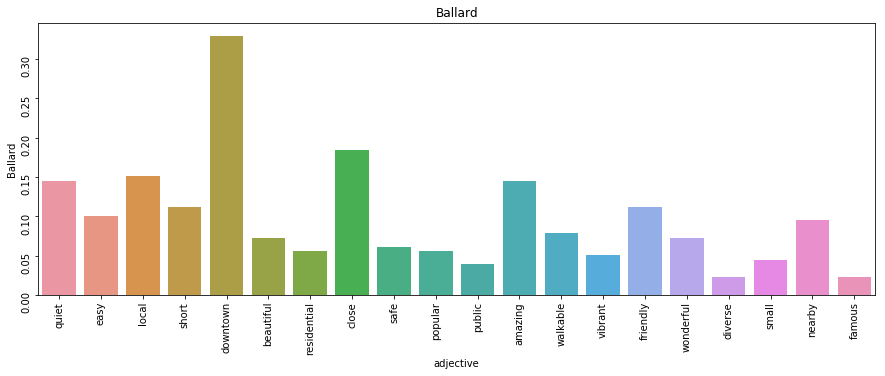

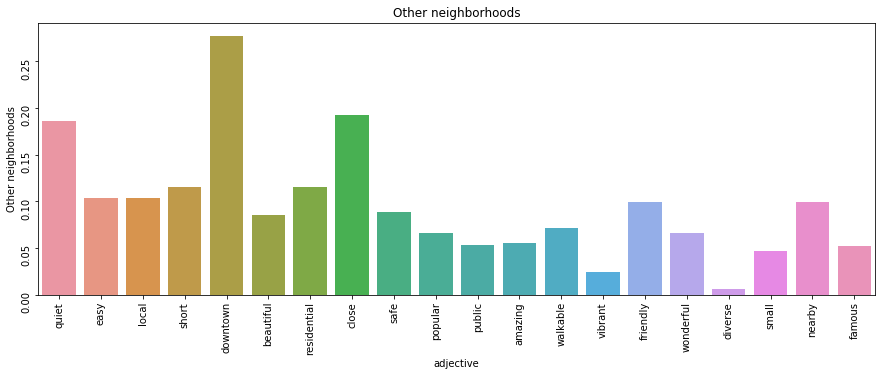

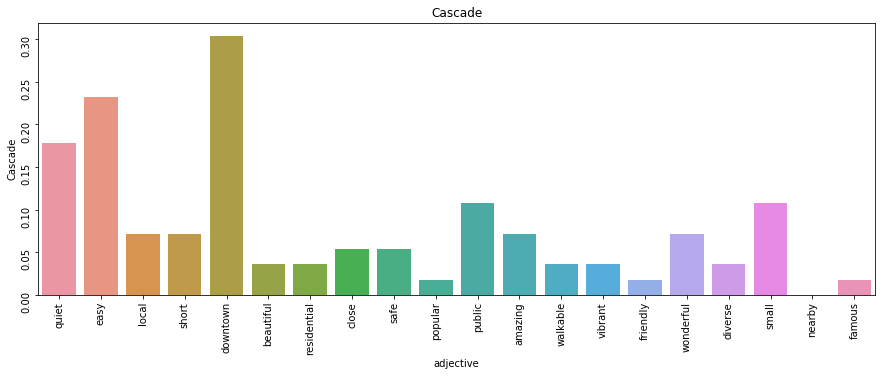

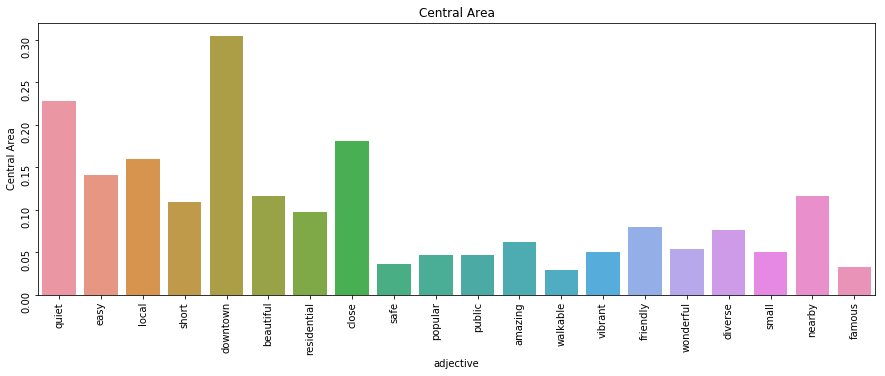

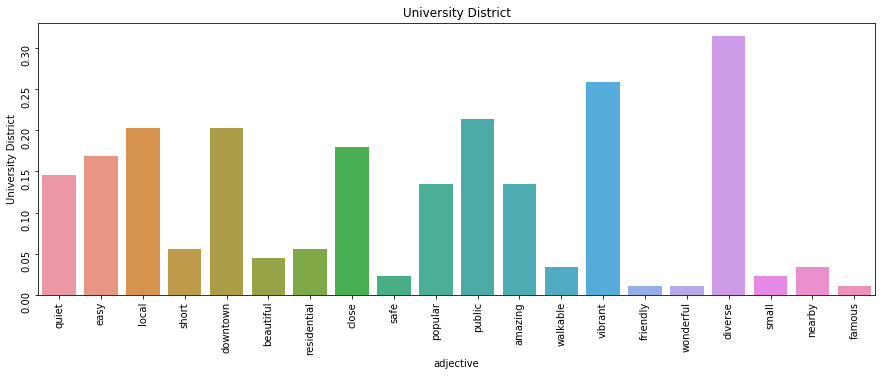

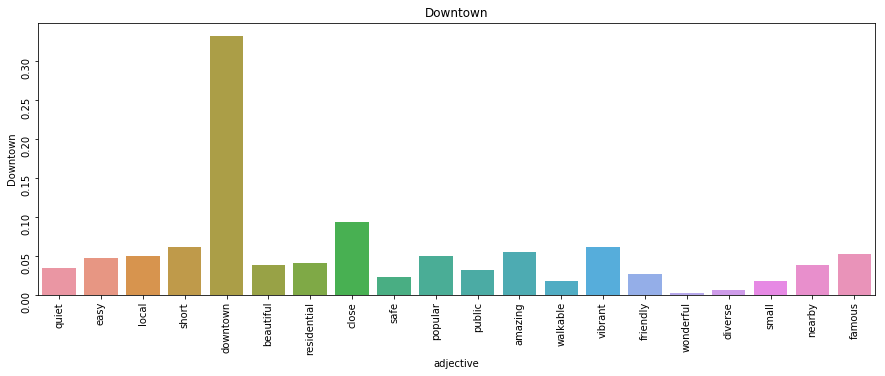

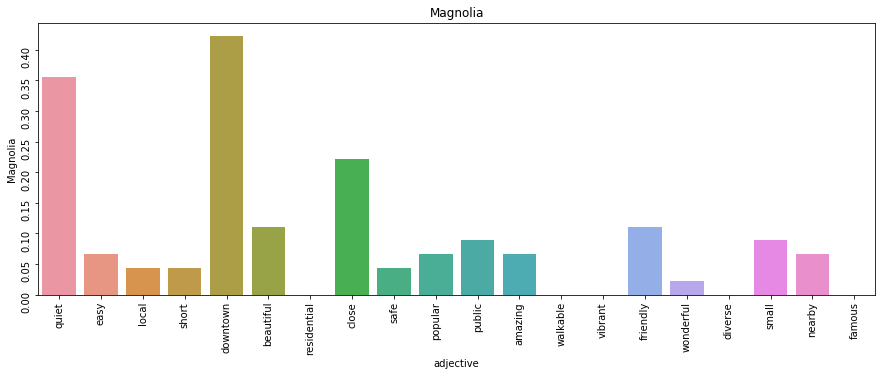

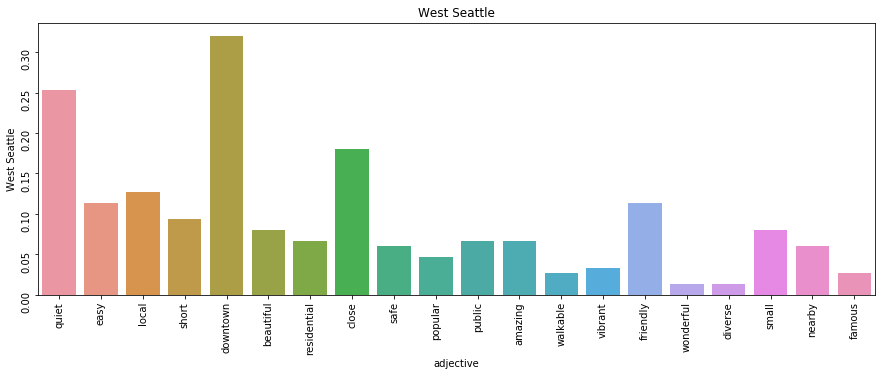

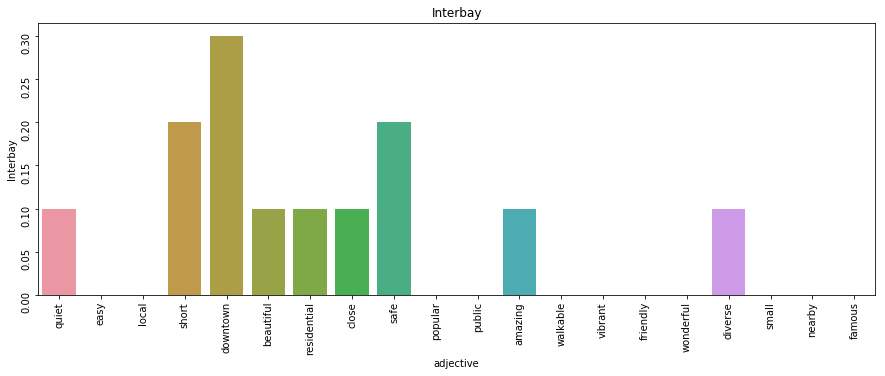

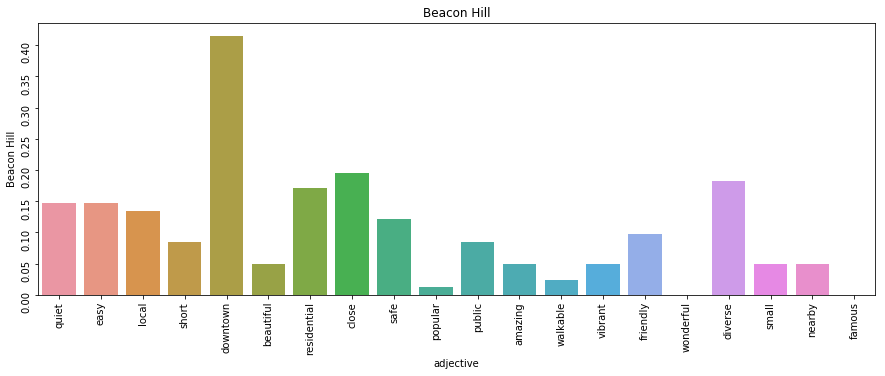

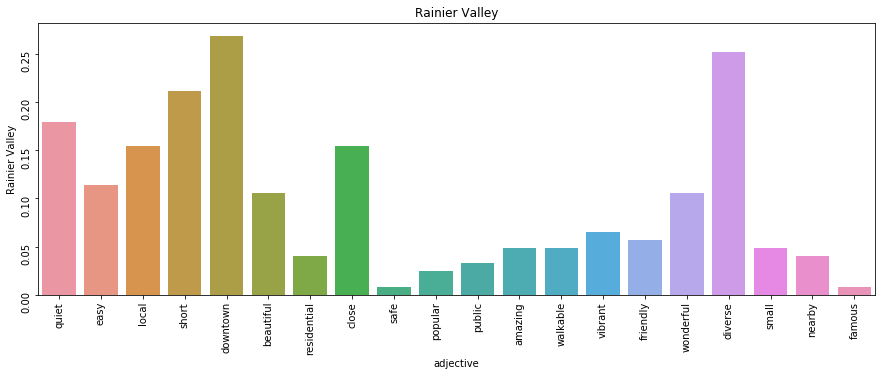

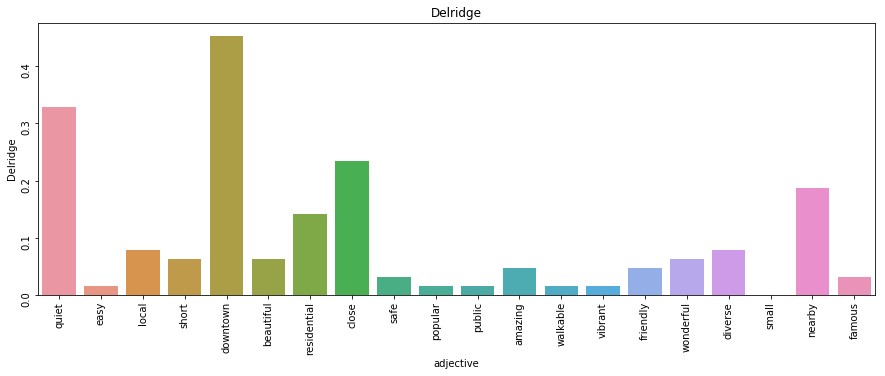

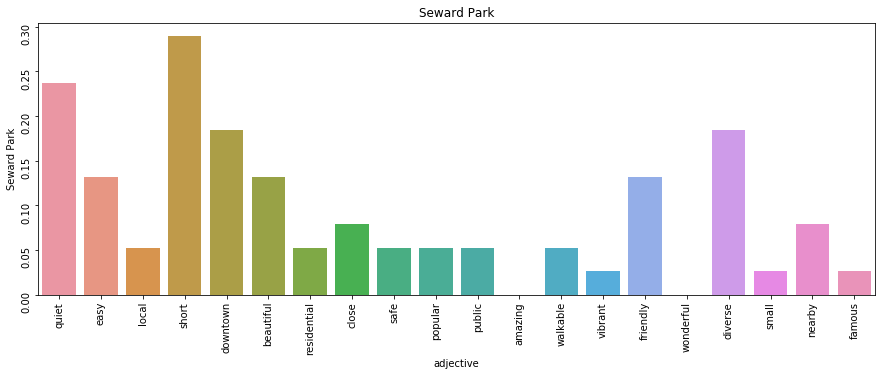

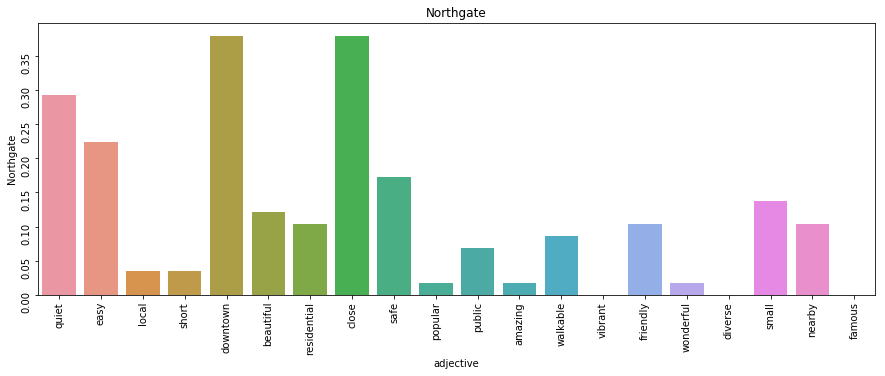

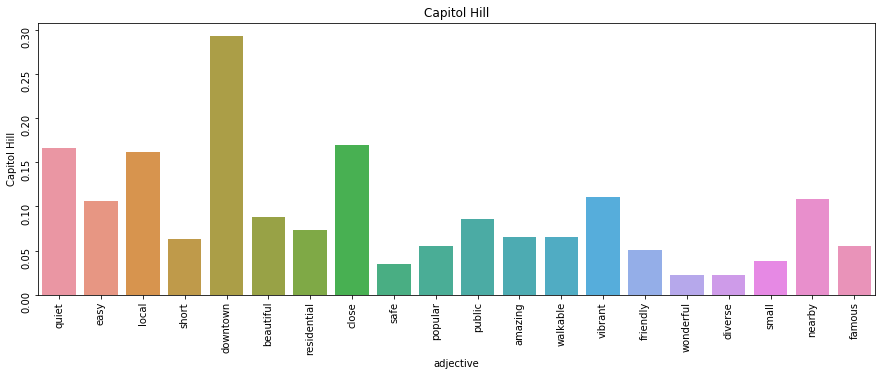

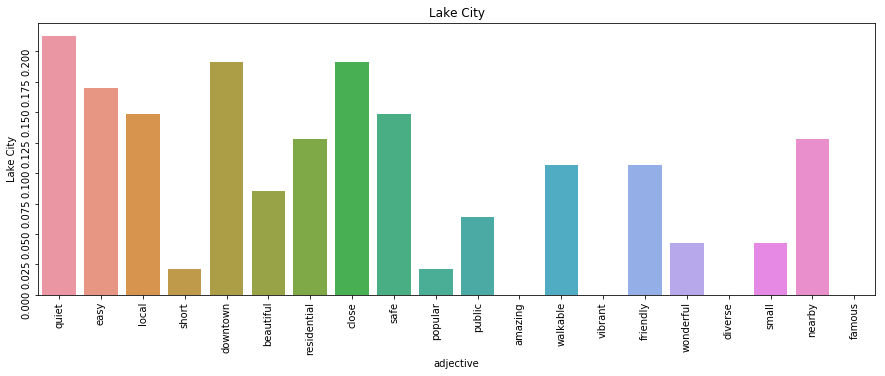

In [144]:
for name in list(lis.neighbourhood_group_cleansed.unique()):
    fig,ax = plt.subplots(1,1,figsize=(15,5))
    sns.barplot(x=location_final['adjective'], y=location_final[name])
    ax.tick_params(labelrotation=90)
    plt.title(name)

### Plot mean amount of mentions per adjective (Each plot is one adjective)

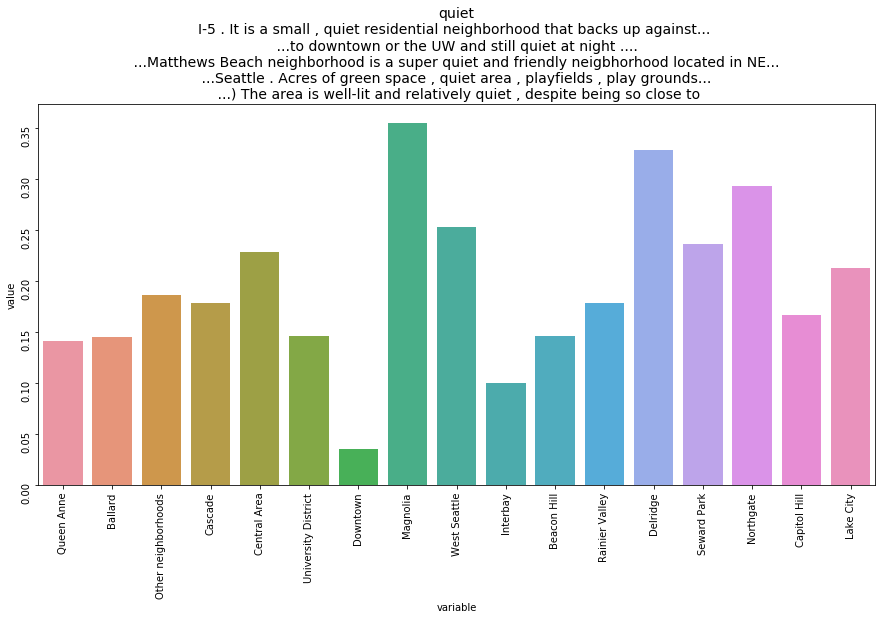

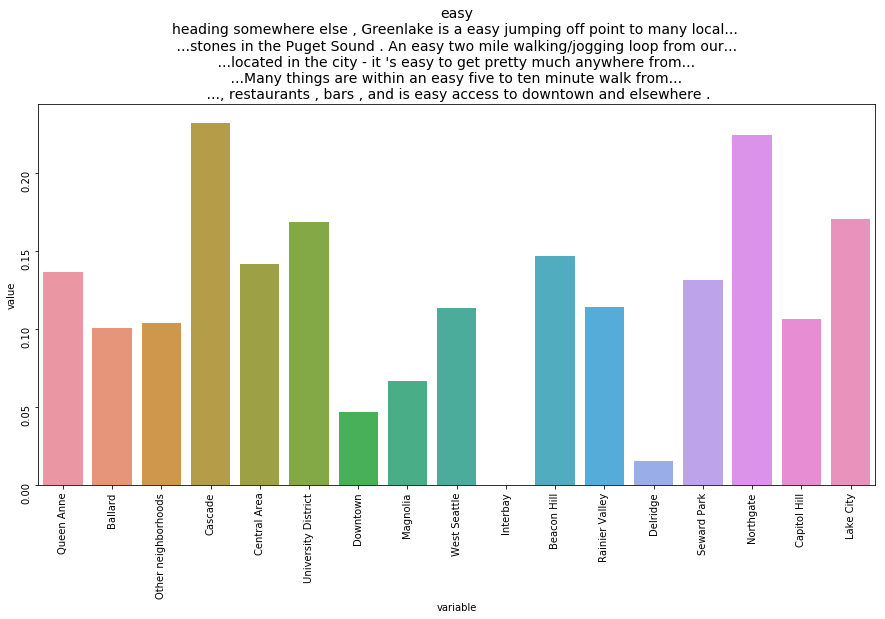

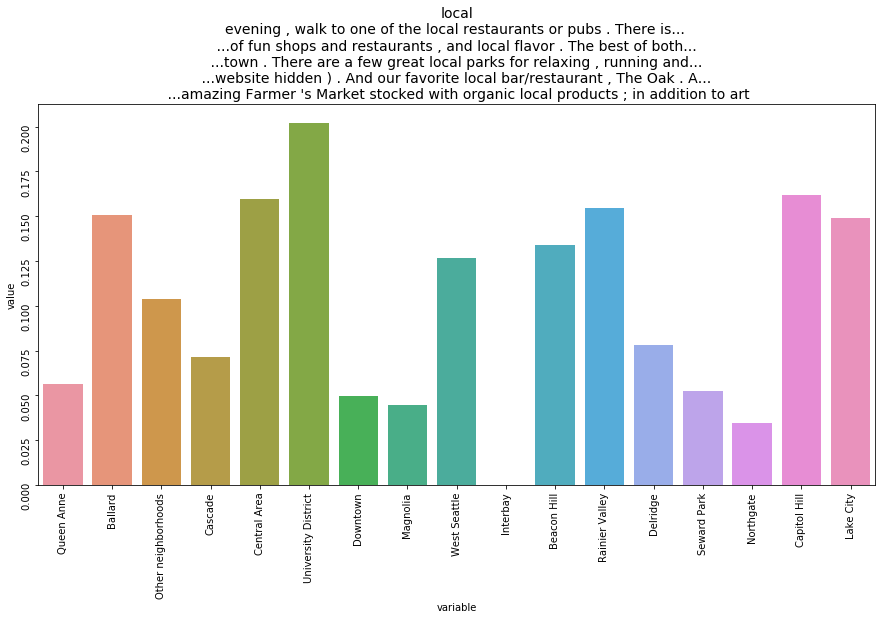

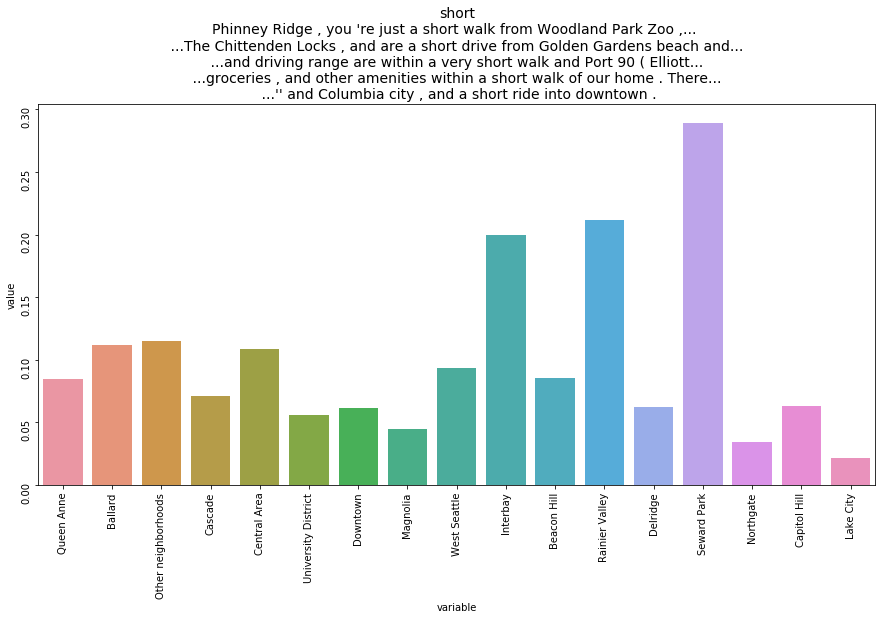

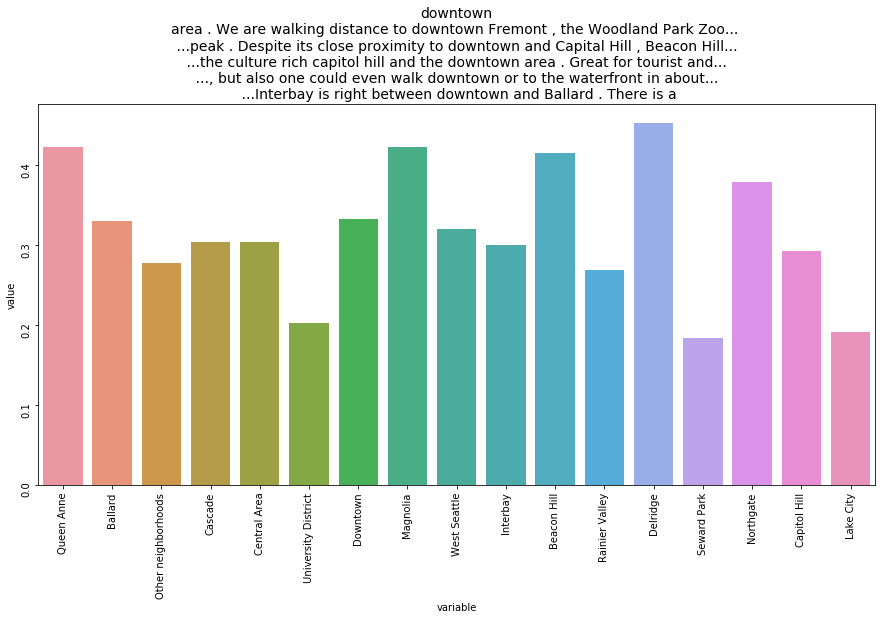

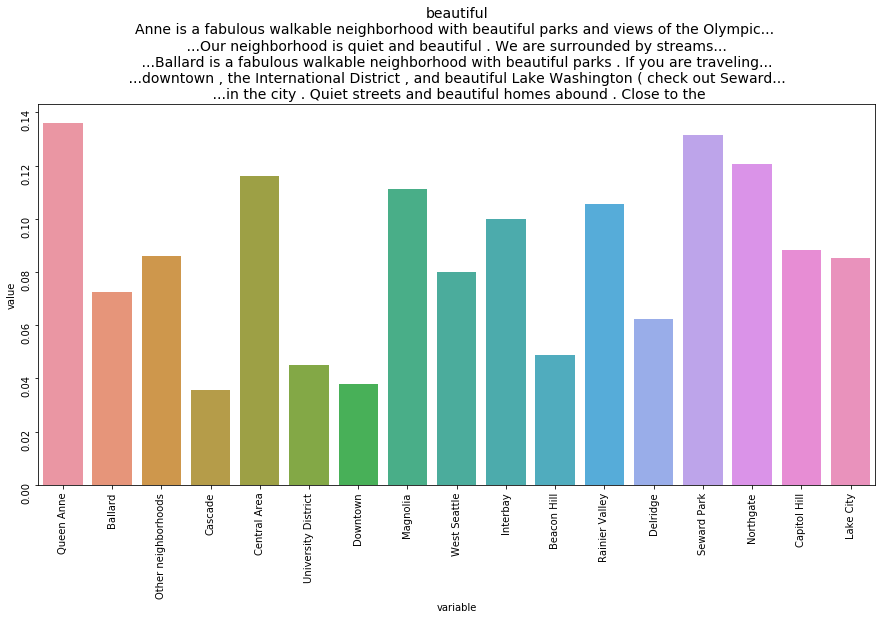

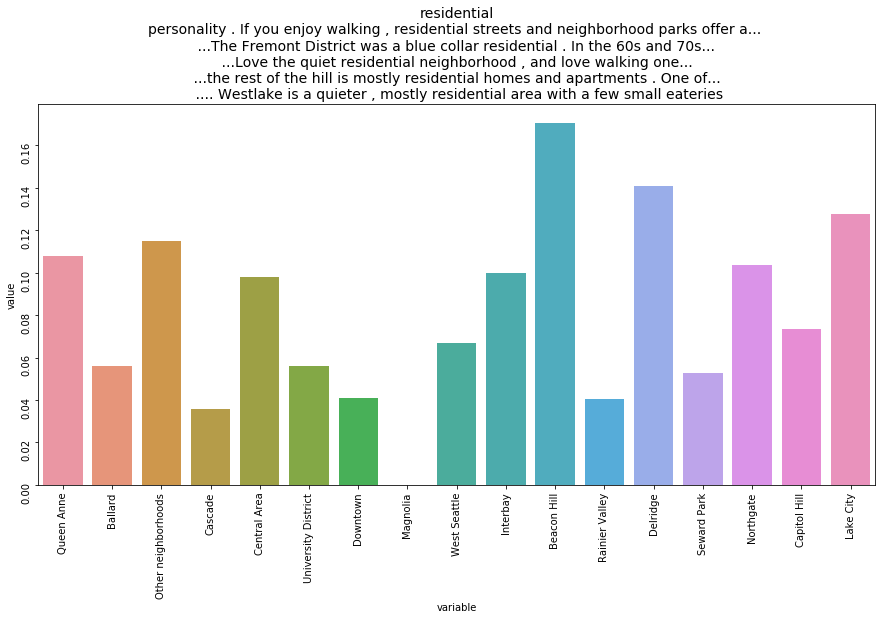

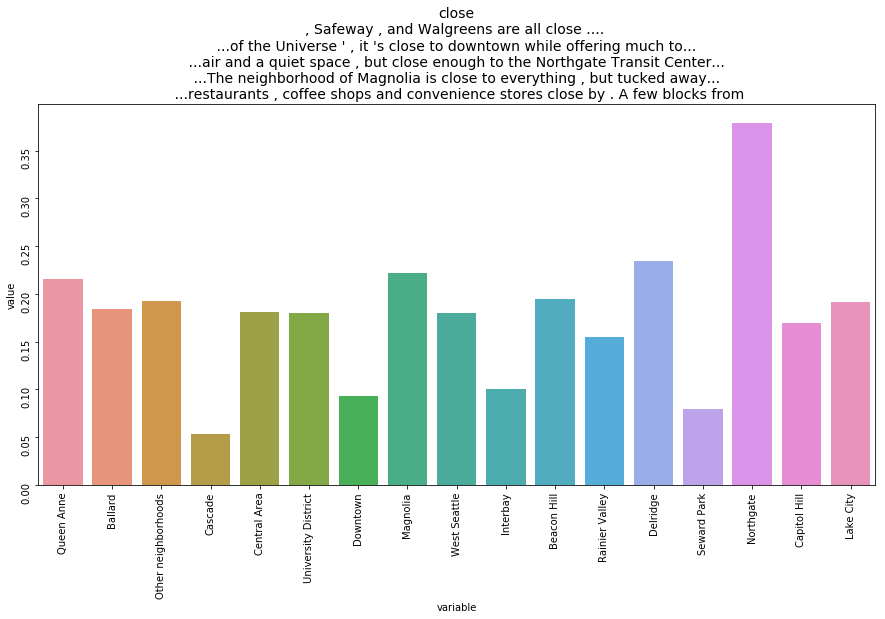

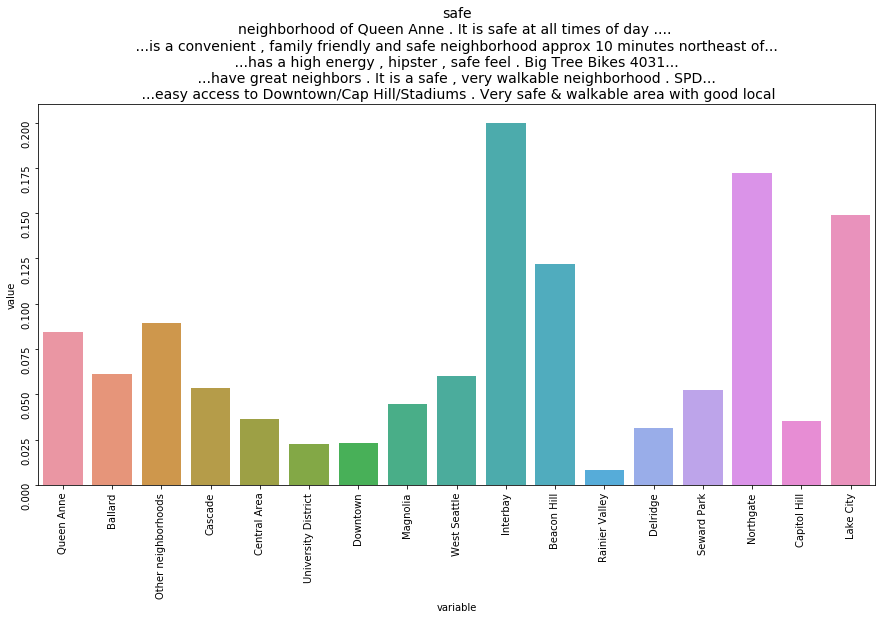

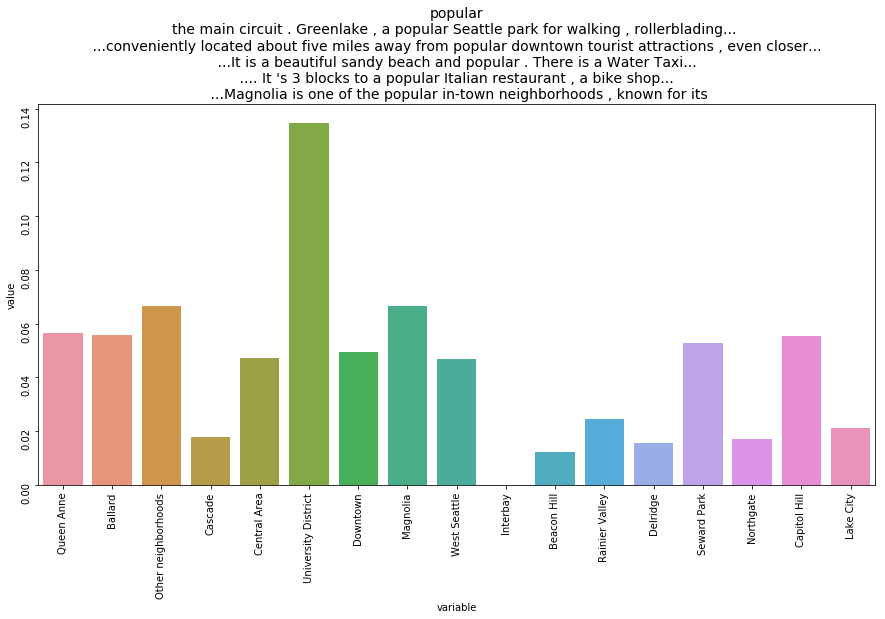

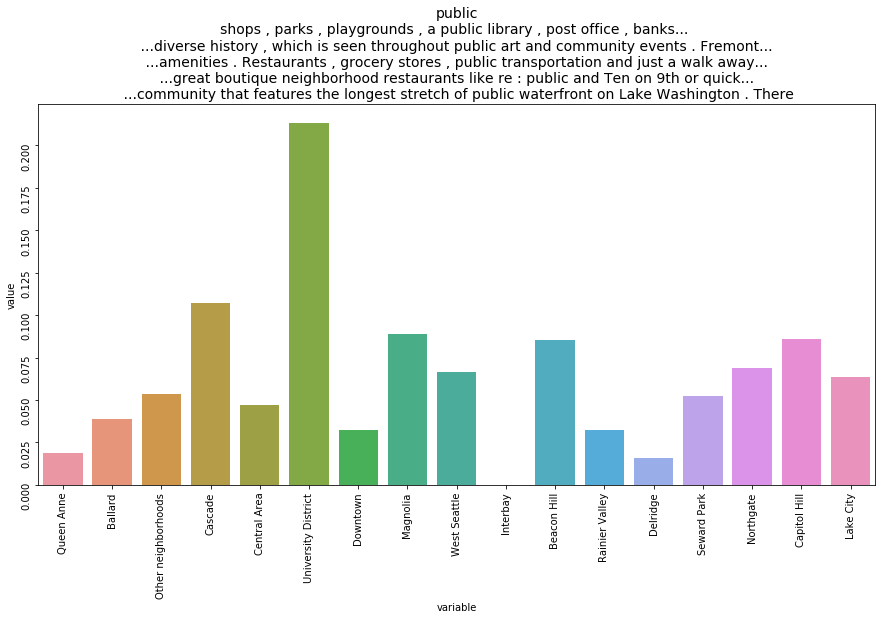

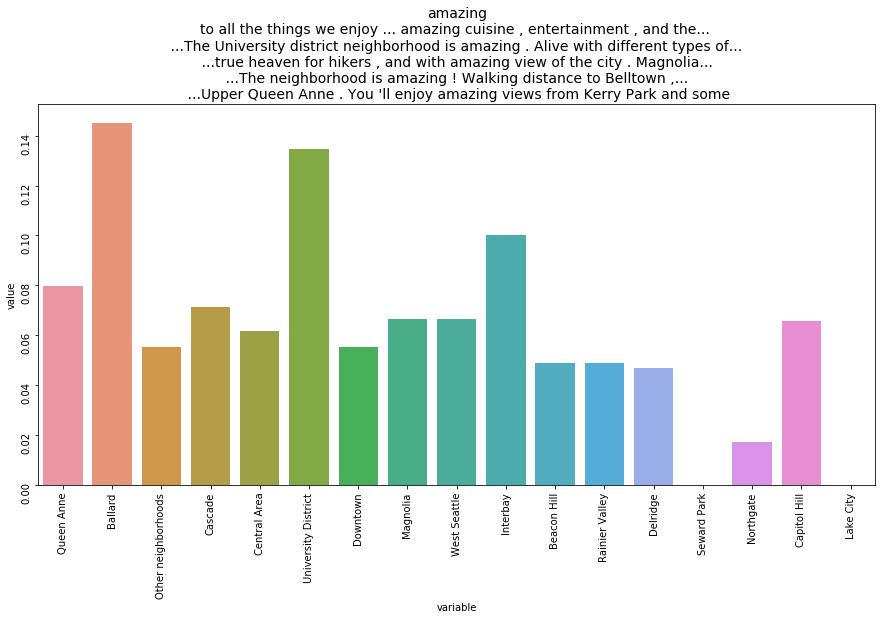

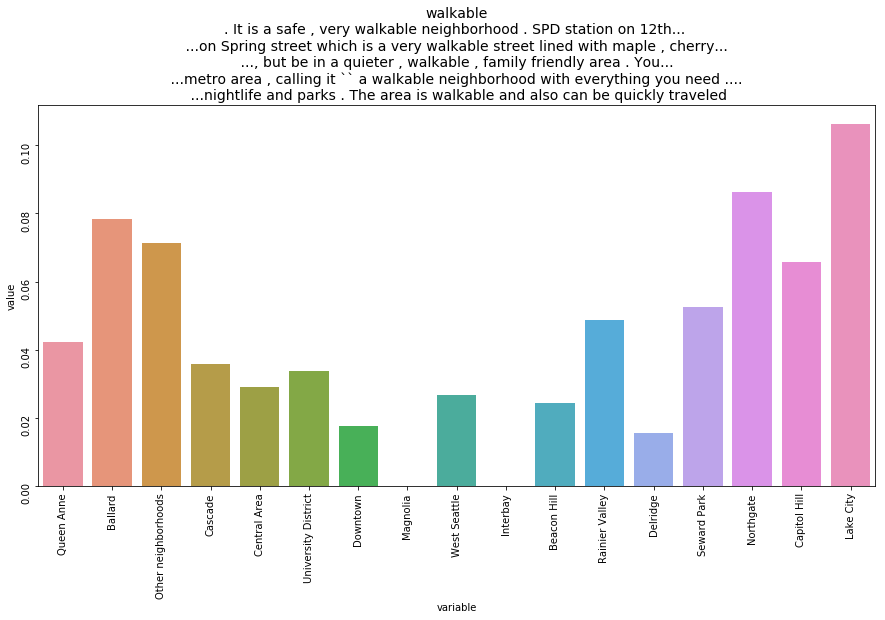

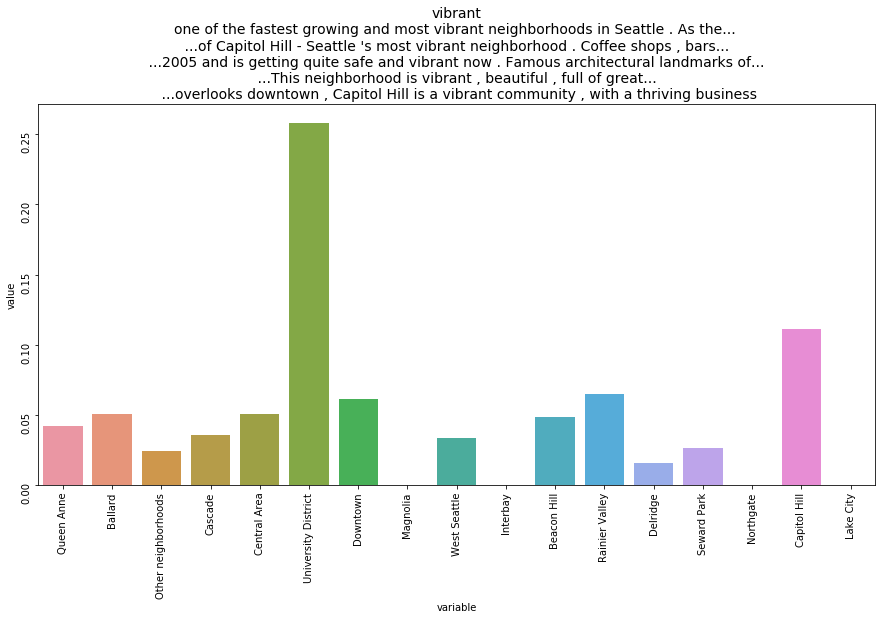

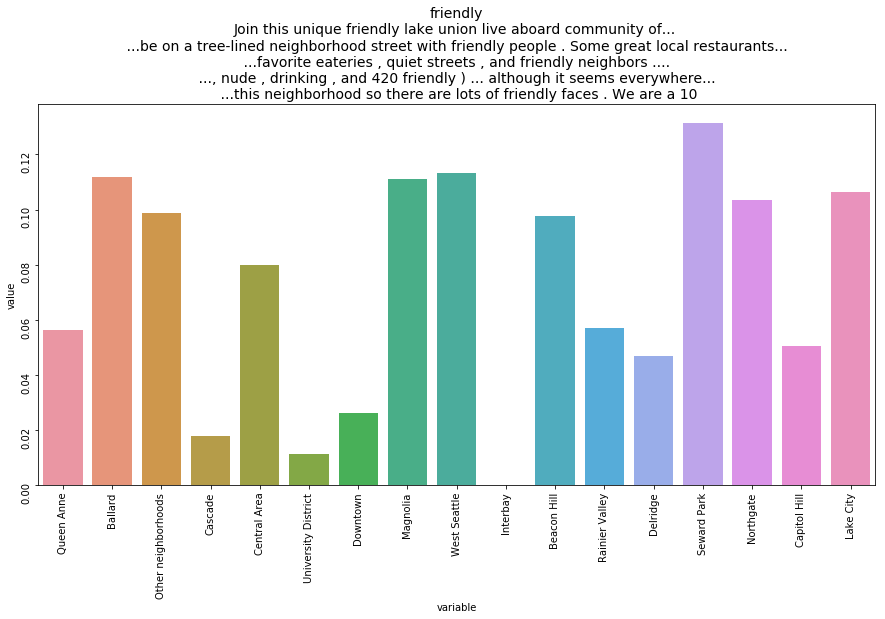

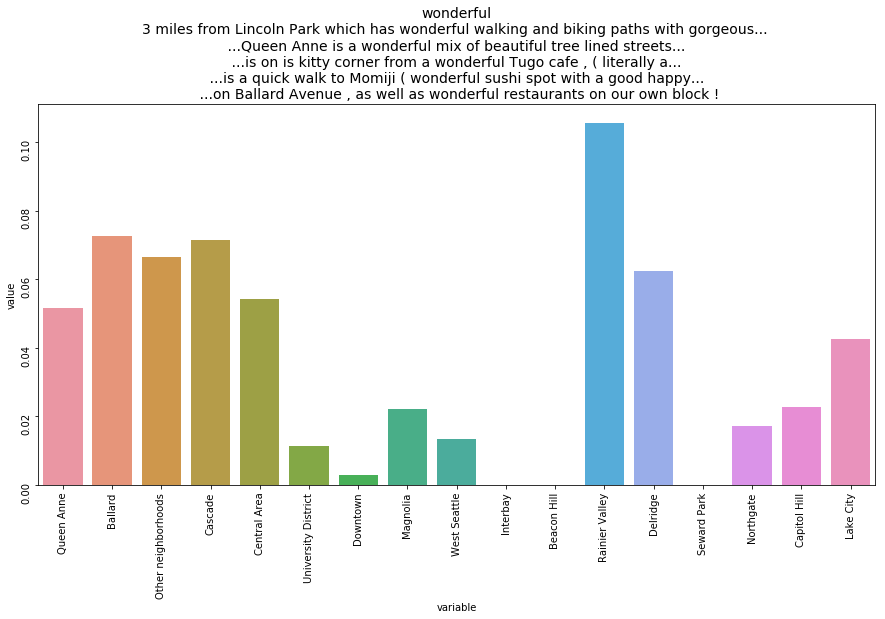

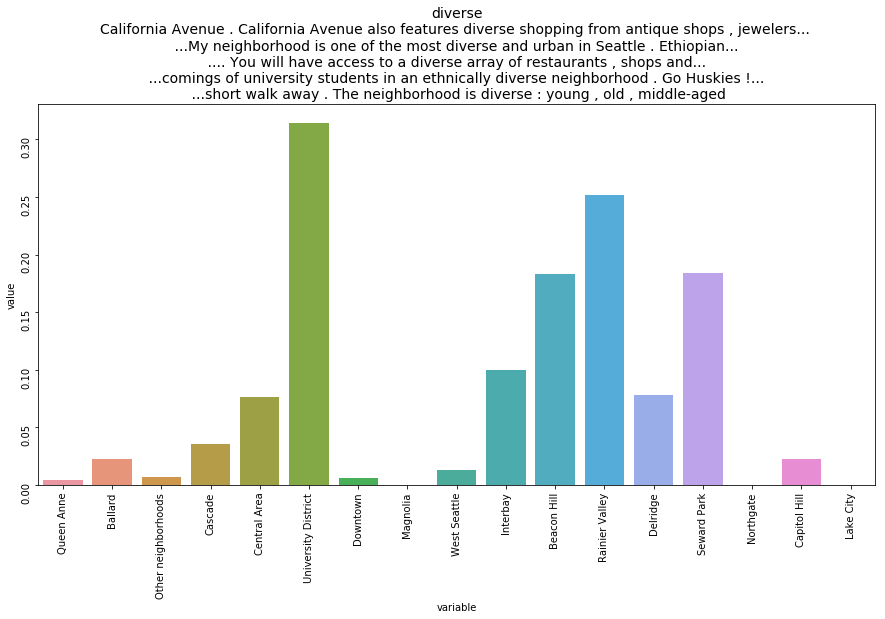

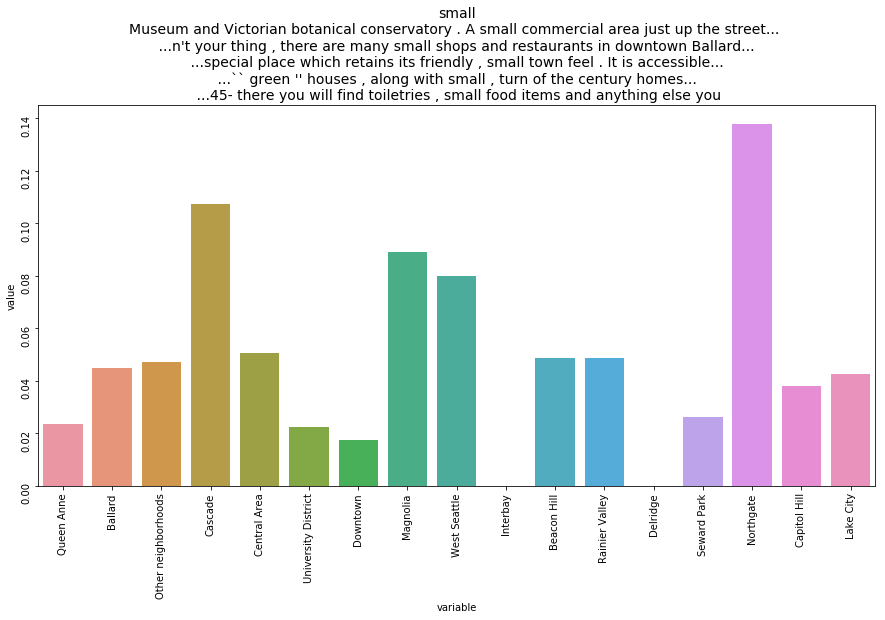

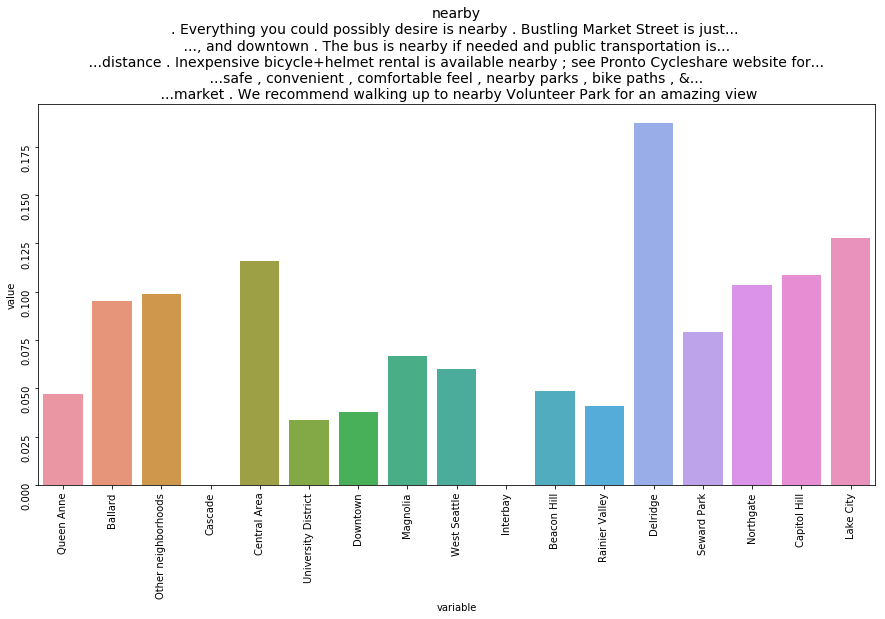

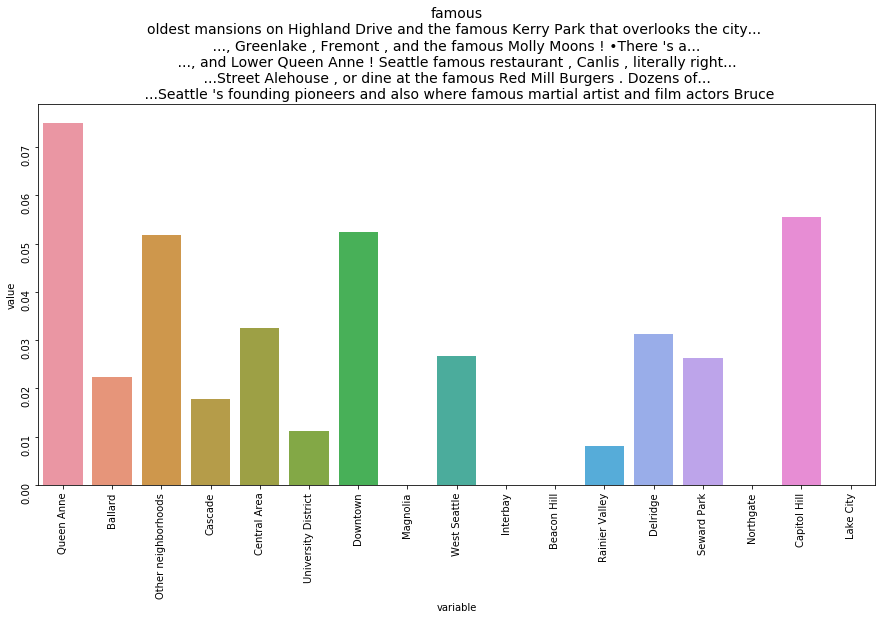

In [145]:
lis['tokenized_neighbourhood'] = [word_tokenize(i) for i in lis['neighborhood_overview'].fillna('')]
for adj in list(location_final['adjective'].unique()):
    fig,ax = plt.subplots(1,1,figsize=(15,7))
    textstr = '... \n ...'.join((
        [' '.join(sentence[sentence.index(adj)-min(7,sentence.index(adj)) :sentence.index(adj) +7]) for sentence in lis[[len(set([adj]).intersection(set(x)))>0 for x in lis.tokenized_neighbourhood]].tokenized_neighbourhood.sample(5, random_state = 42)]

        ))
    sns.barplot(x=district_melt[district_melt.adjective == adj]['variable'], y=district_melt[district_melt.adjective == adj]['value'])
    ax.tick_params(labelrotation=90)
    plt.title(adj + '\n' +textstr, fontsize=14)

## Find describing nouns of location

In [146]:
noun_tags = ["NN", "NNP", "NNS"]
noun_df = tokenize_and_extract(lis, 'neighborhood_overview', noun_tags, 'noun')

Drop non-important or unclear nouns

In [147]:
top_noun_loc = noun_df[~(noun_df.noun.isin(['seattle', 'neighborhood', 'blocks', 'city', 'downtown', 'street', 'fremont', 'district', 'most', 'less', 'ballard']))]['noun'].value_counts().head(30)
top_noun_loc.head()

restaurants    1631
park           1170
hill            954
walk            948
shops           850
Name: noun, dtype: int64

### Create dataframe with mean amount of mentions per noun

In [149]:
location_final = avg_mentions_per_type(lis, 'neighborhood_overview', top_noun_loc, 'noun') 

In [150]:
location_final.head()

noun  Queen Anne   Ballard  Other neighborhoods   Cascade  \
0  restaurants    0.516432  0.664804             0.567261  0.482143   
1         park    0.201878  0.240223             0.307942  0.178571   
2         hill    0.267606  0.027933             0.069692  0.089286   
3         walk    0.563380  0.569832             0.576985  0.357143   
4        shops    0.356808  0.301676             0.341977  0.178571   

   Central Area  University District  Downtown  Magnolia  West Seattle  \
0      0.507246             0.516854  0.437318  0.288889      0.500000   
1      0.300725             0.157303  0.058309  0.400000      0.226667   
2      0.144928             0.011236  0.014577  0.088889      0.113333   
3      0.550725             0.539326  0.419825  0.422222      0.560000   
4      0.278986             0.505618  0.192420  0.133333      0.286667   

   Interbay  Beacon Hill  Rainier Valley  Delridge  Seward Park  Northgate  \
0       0.4     0.475610        0.471545  0.375000     0.526316   0.431034   
1       0.2     0.292683        0.349593  0.312500     0.342105   0.362069   
2       0.1     0.146341        0.040650  0.031250     0.052632   0.051724   
3       0.4     0.463415        0.699187  0.421875     0.657895   0.517241   
4       0.5     0.292683        0.252033  0.171875     0.236842   0.241379   

   Capitol Hill  Lake City  
0      0.542929   0.297872  
1      0.270202   0.361702  
2      0.085859   0.063830  
3      0.553030   0.489362  
4      0.257576   0.106383

Transform dataframe for easier plotting in seaborn

In [151]:
district_melt = pd.melt(location_final, id_vars=['noun'], value_vars=list(lis.neighbourhood_group_cleansed.unique()))
district_melt.head()

noun    variable     value
0  restaurants  Queen Anne  0.516432
1         park  Queen Anne  0.201878
2         hill  Queen Anne  0.267606
3         walk  Queen Anne  0.563380
4        shops  Queen Anne  0.356808

### Plot mean amount of mentions per noun (Each plot is one neighborhood)

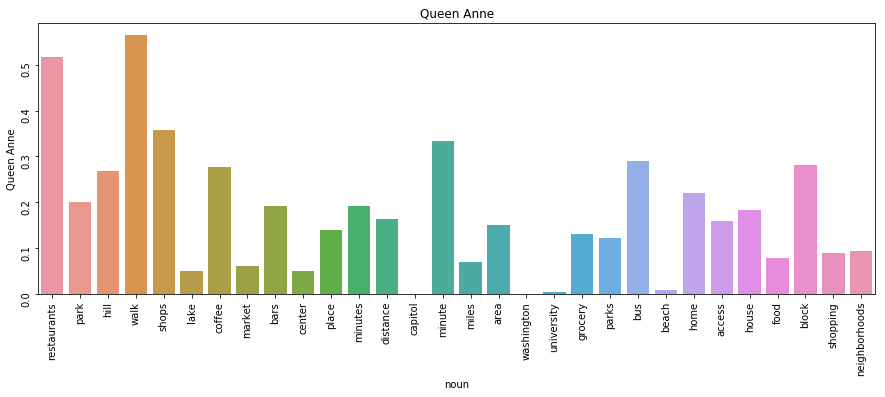

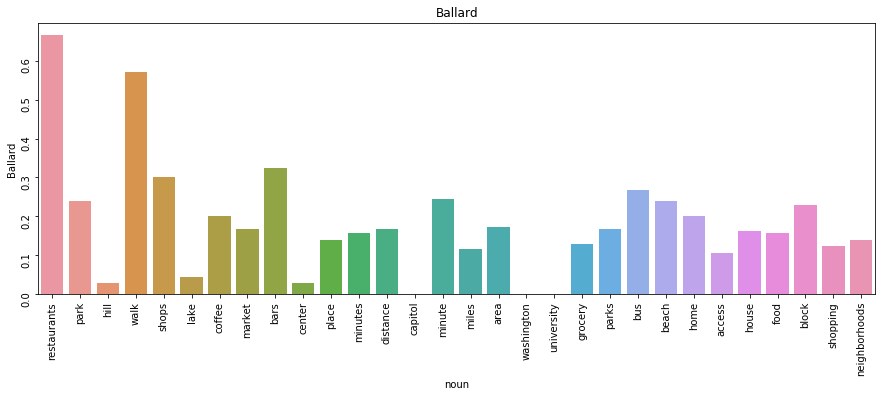

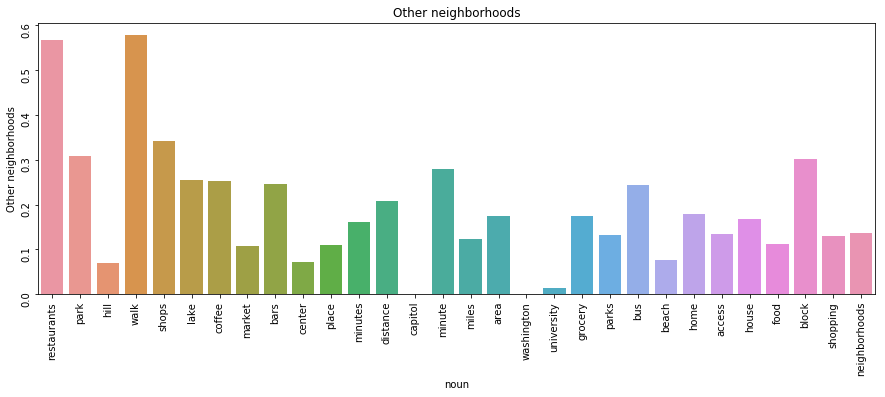

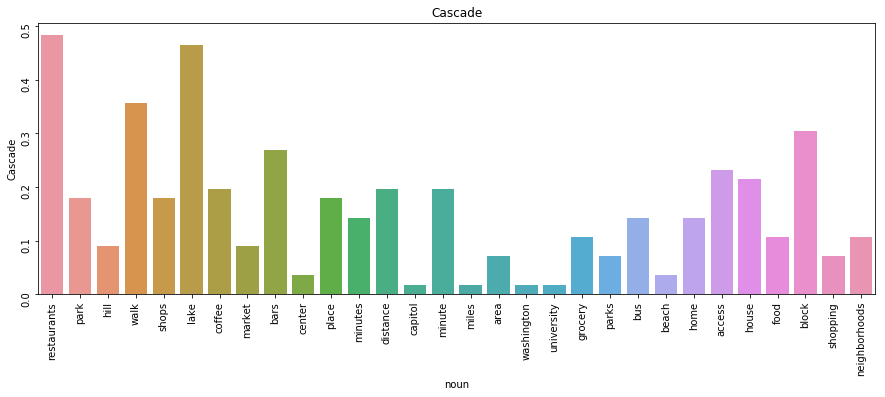

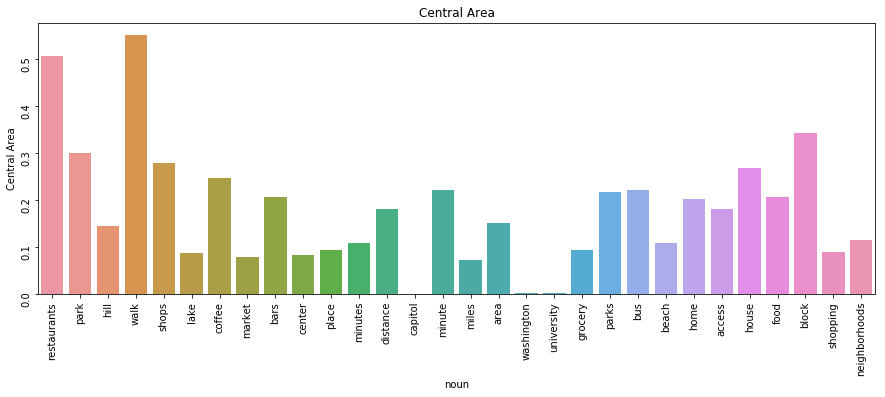

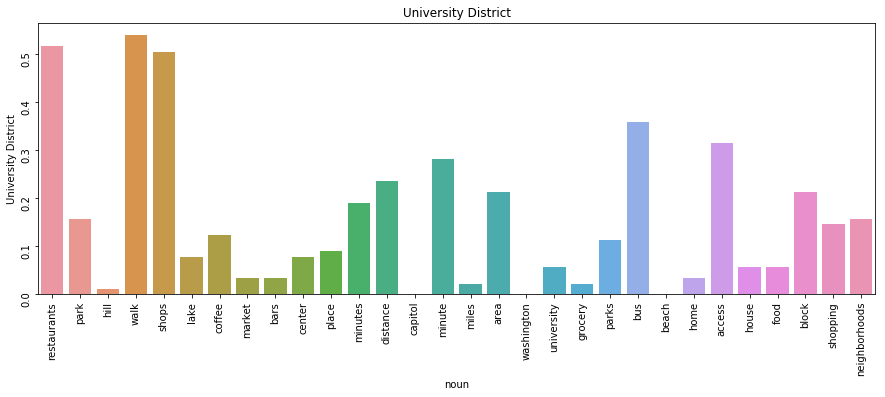

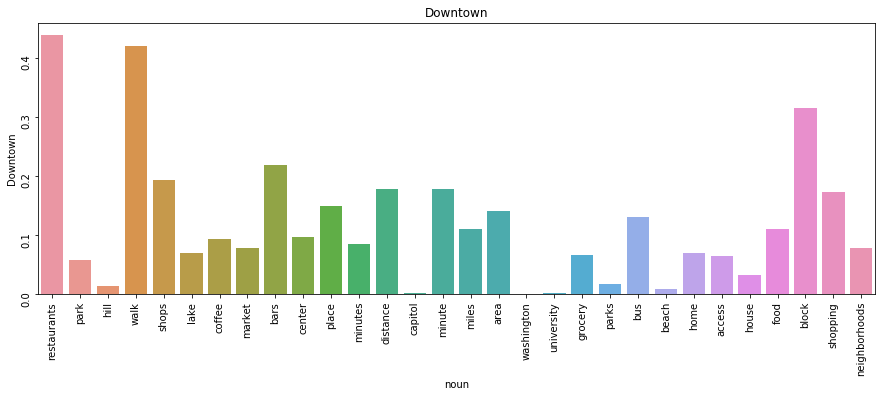

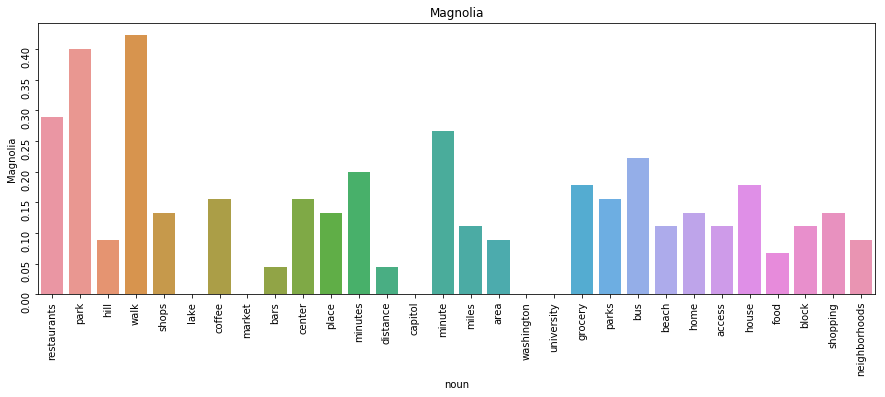

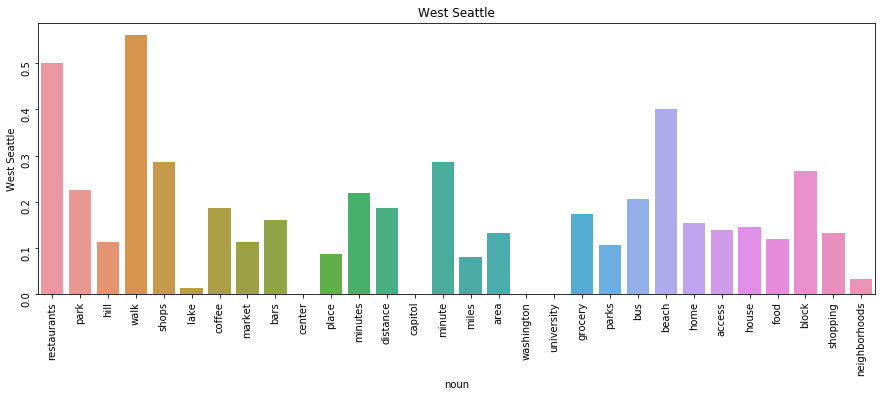

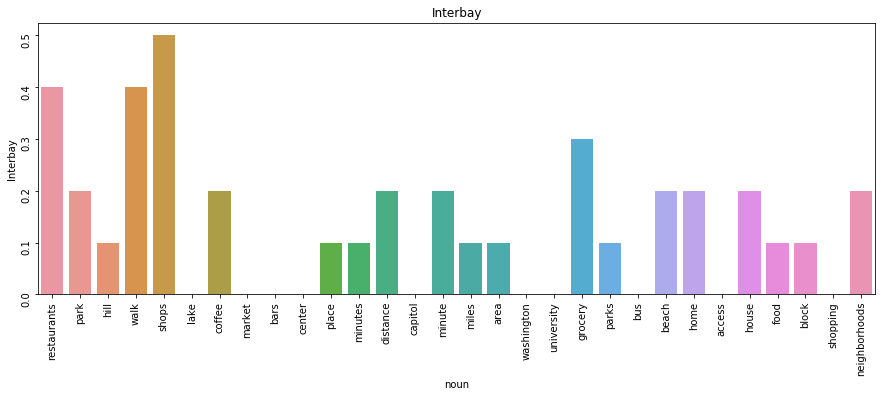

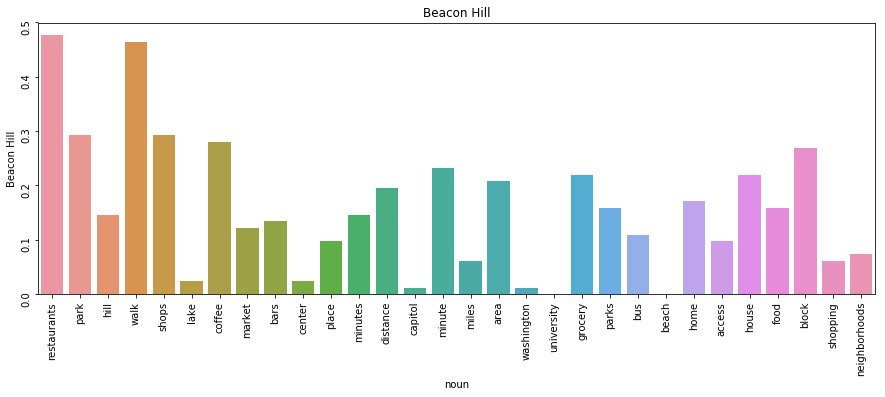

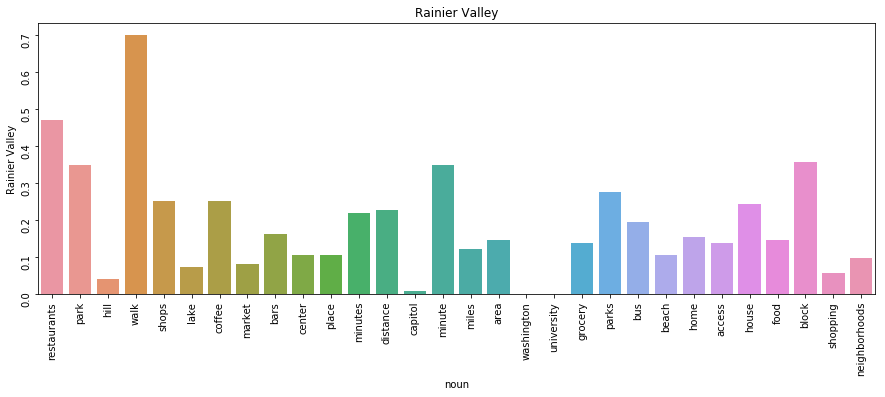

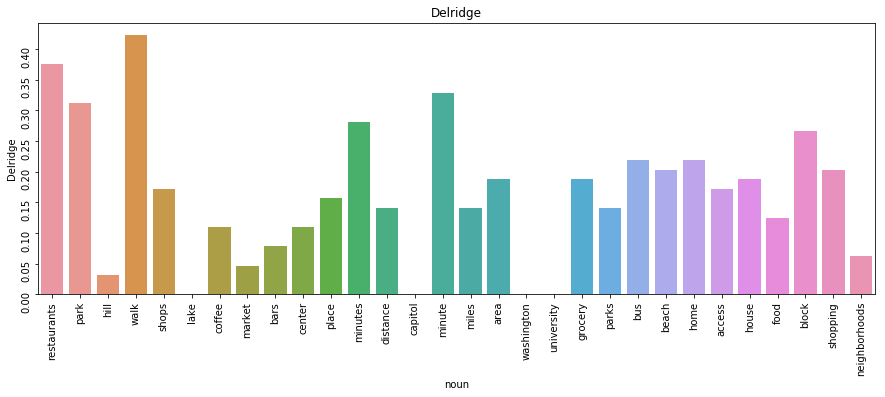

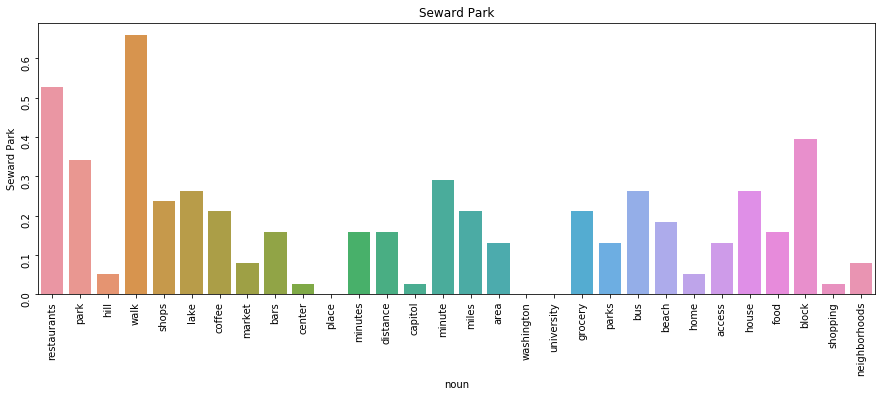

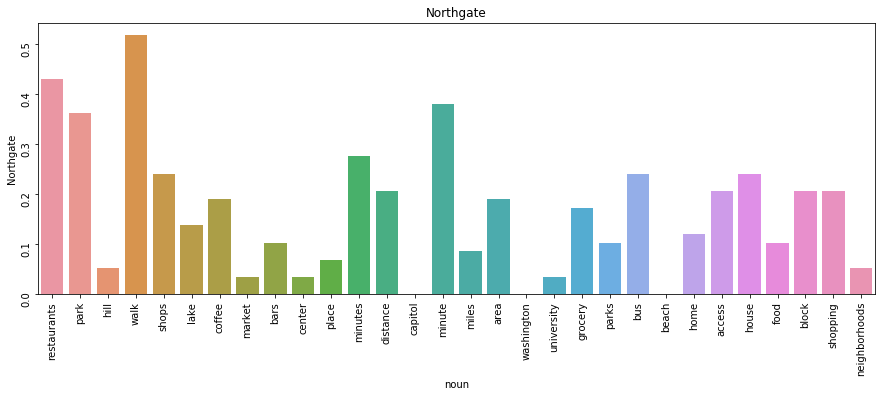

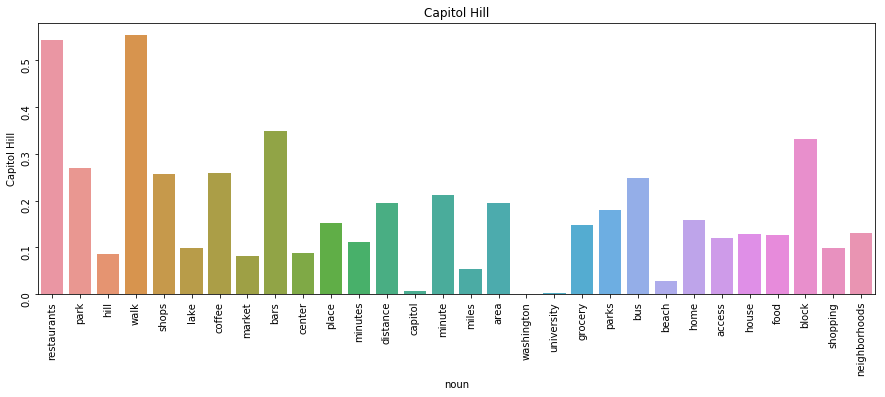

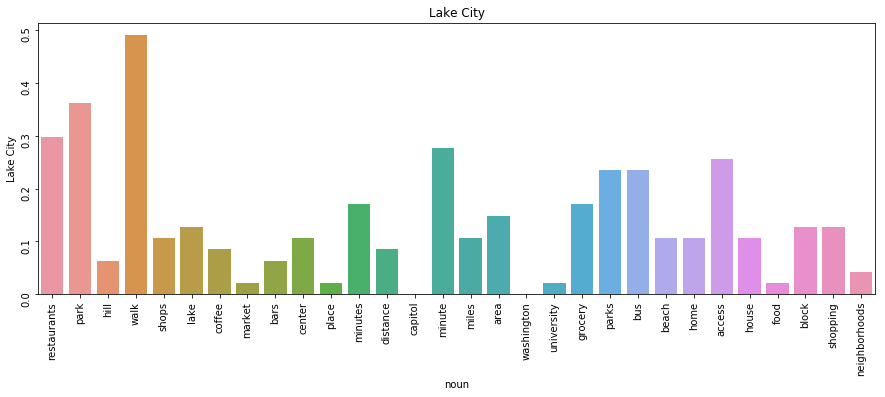

In [152]:
for name in list(lis.neighbourhood_group_cleansed.unique()):
    fig,ax = plt.subplots(1,1,figsize=(15,5))
    sns.barplot(x=location_final['noun'], y=location_final[name])
    ax.tick_params(labelrotation=90)
    plt.title(name)

### Plot mean amount of mentions per noun (Each plot is one noun)

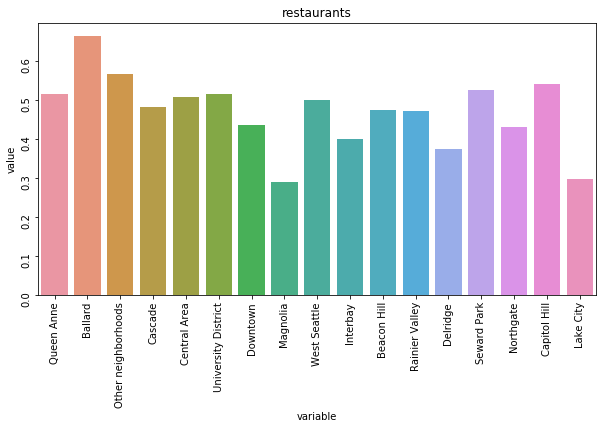

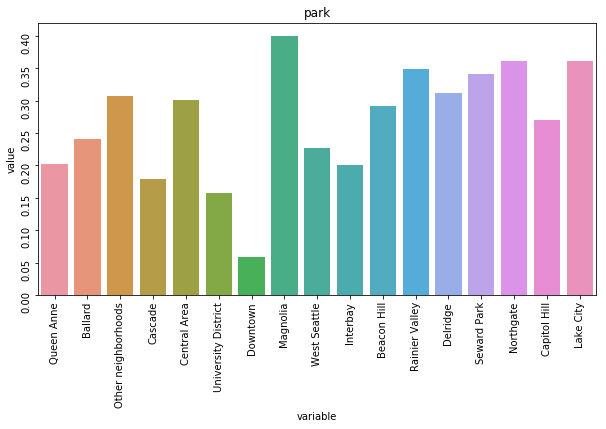

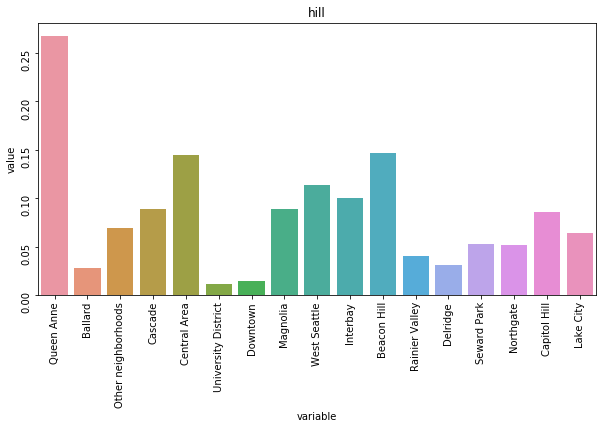

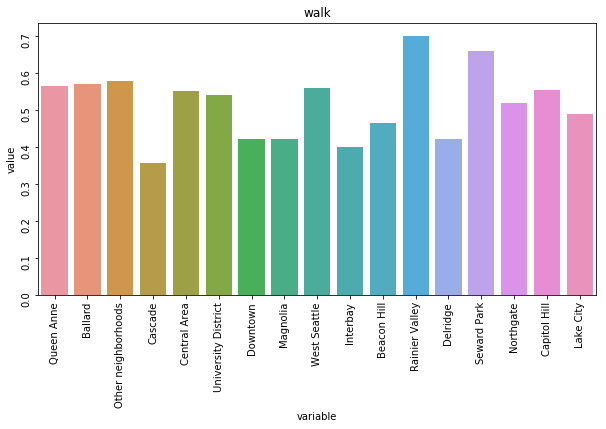

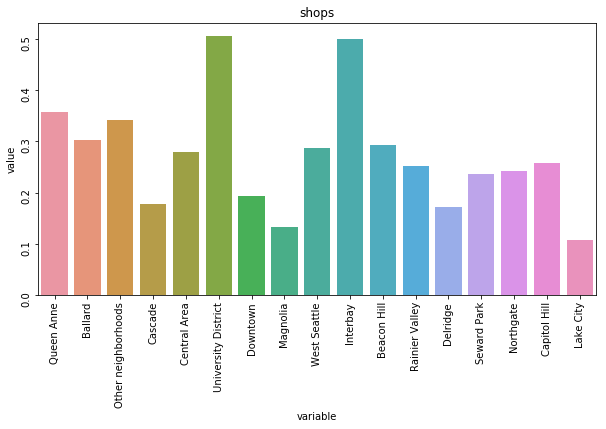

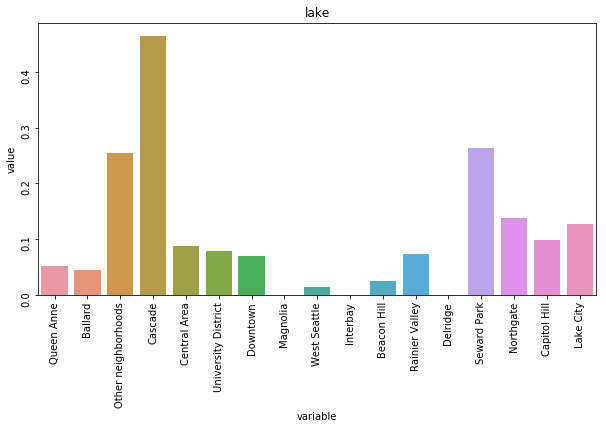

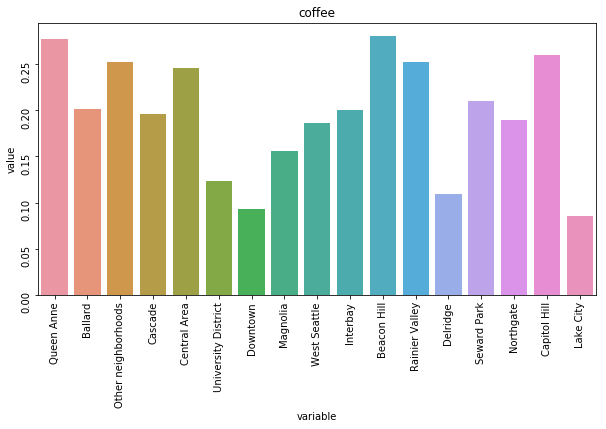

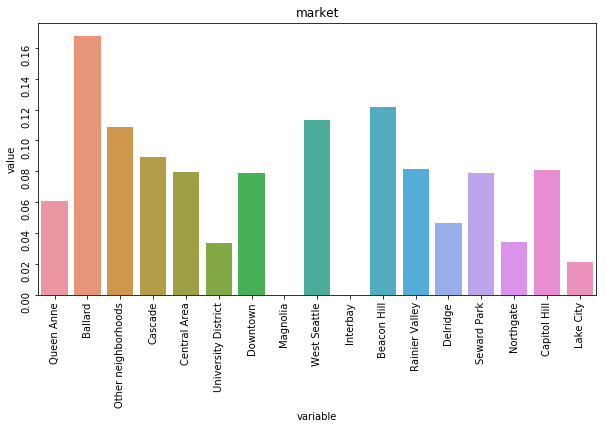

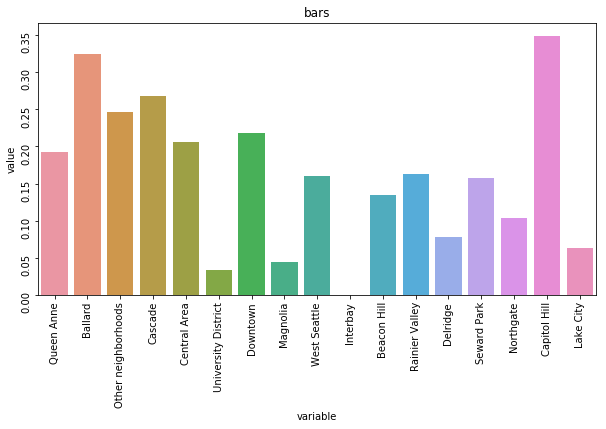

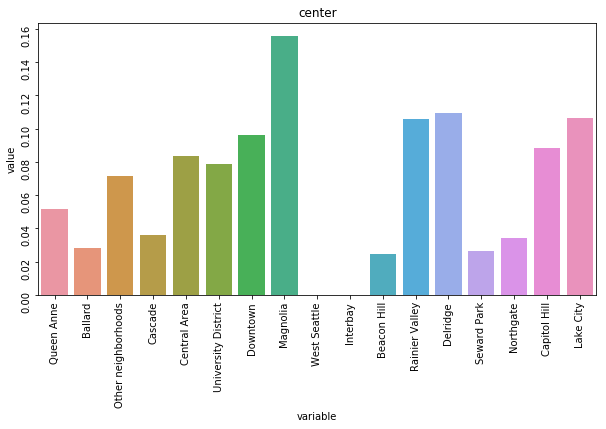

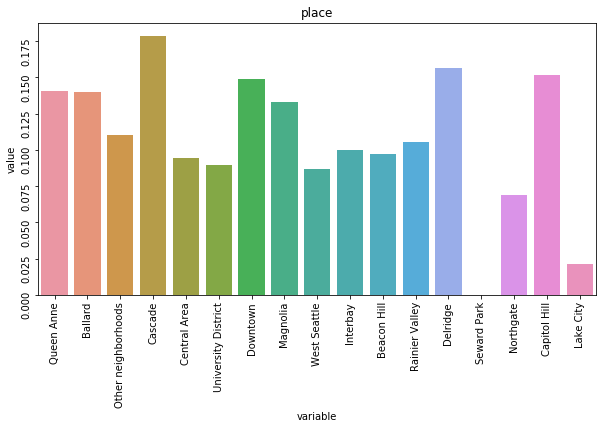

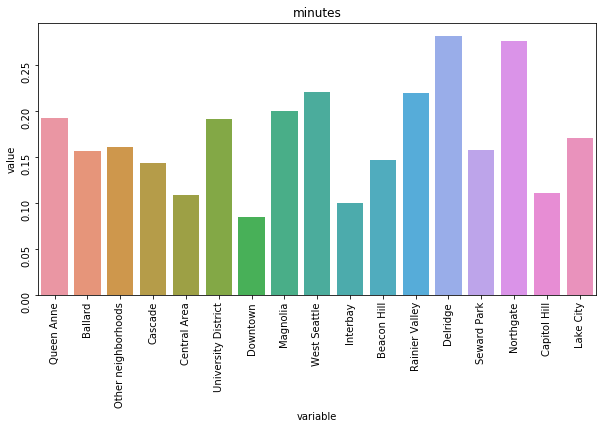

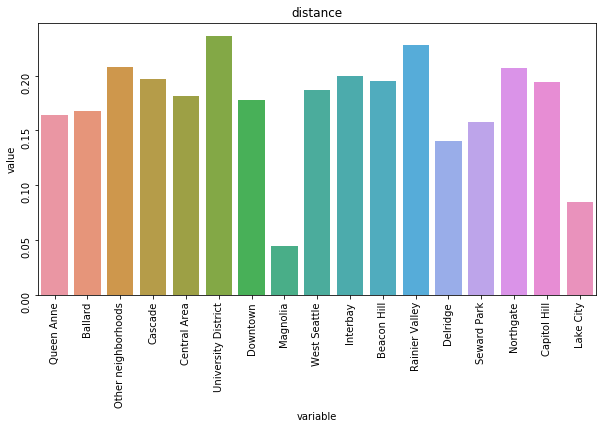

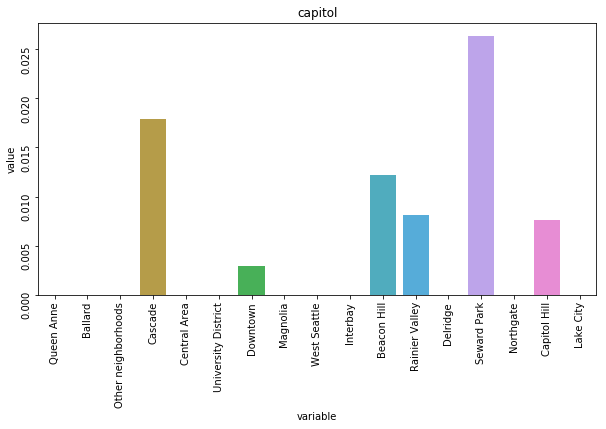

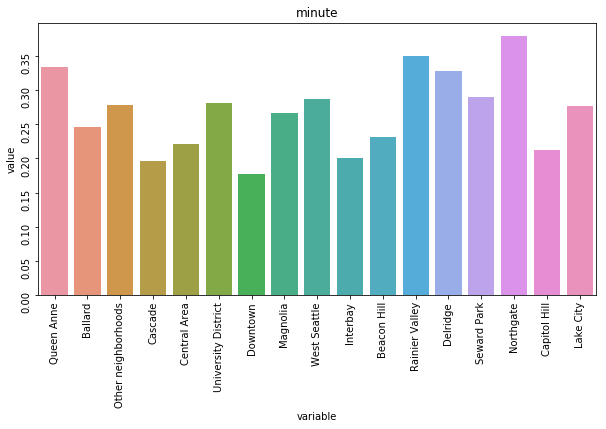

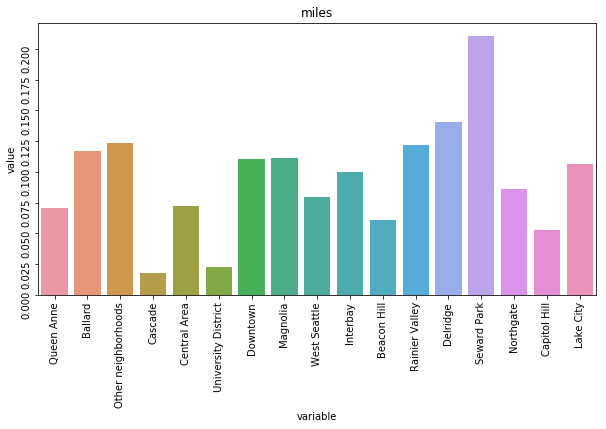

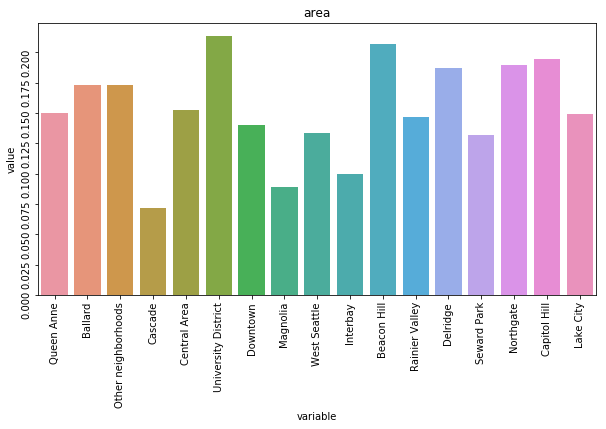

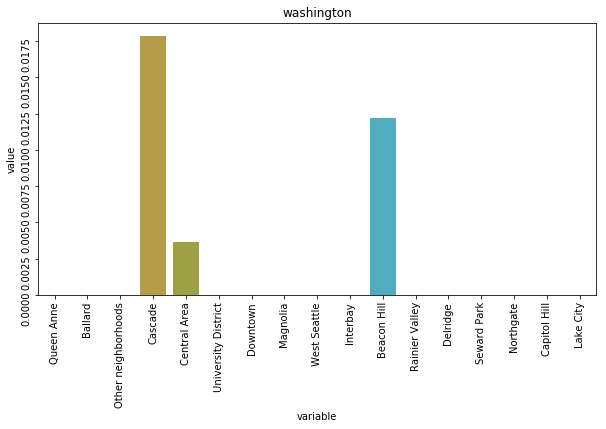

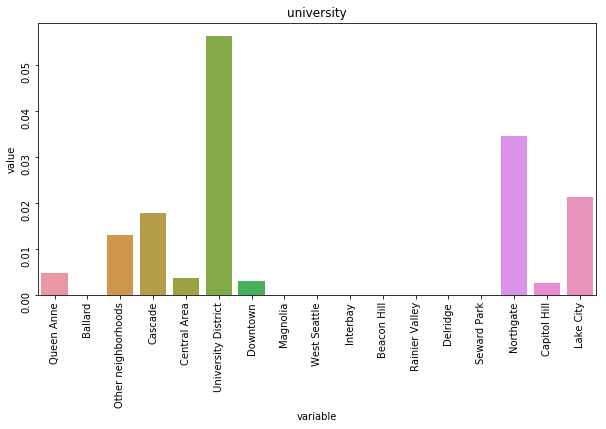

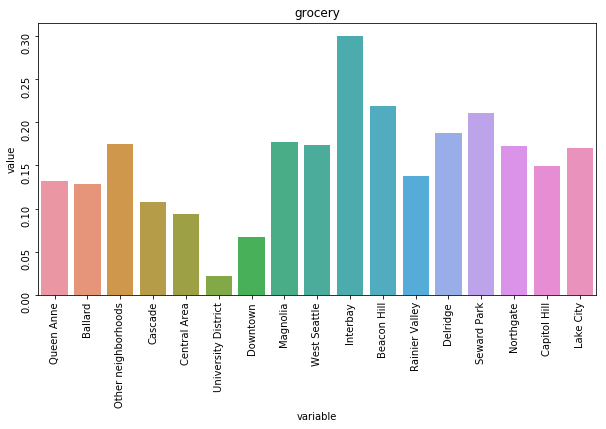

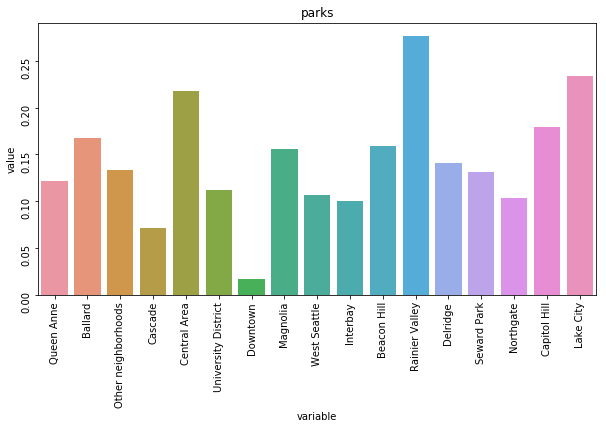

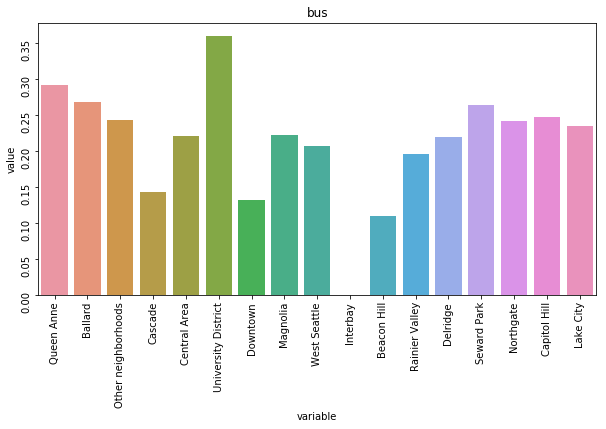

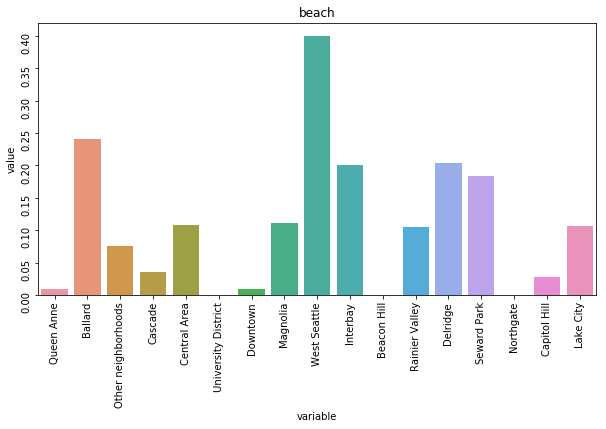

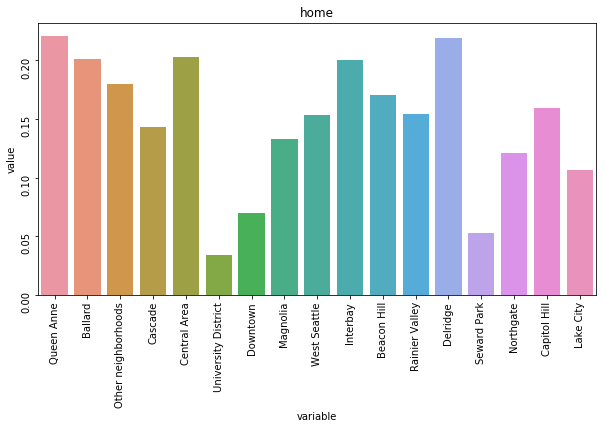

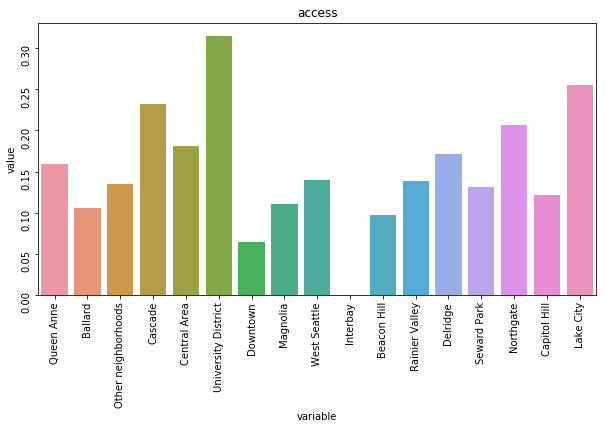

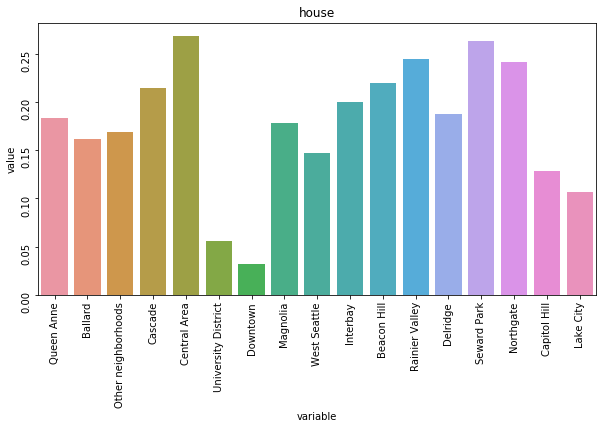

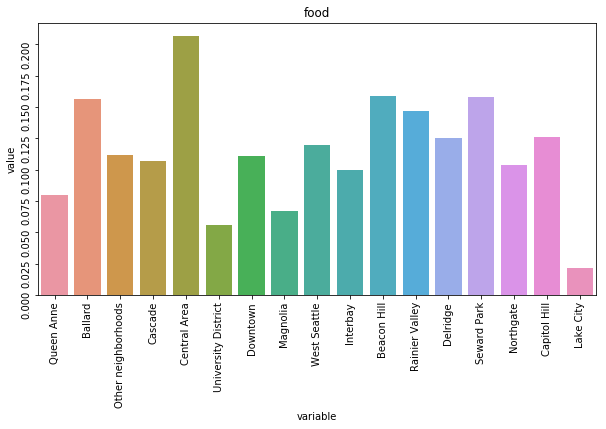

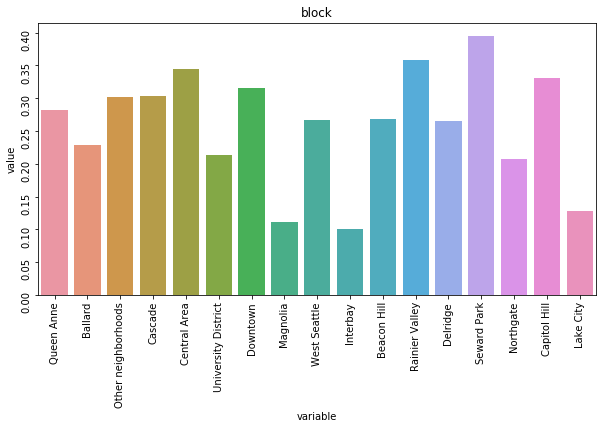

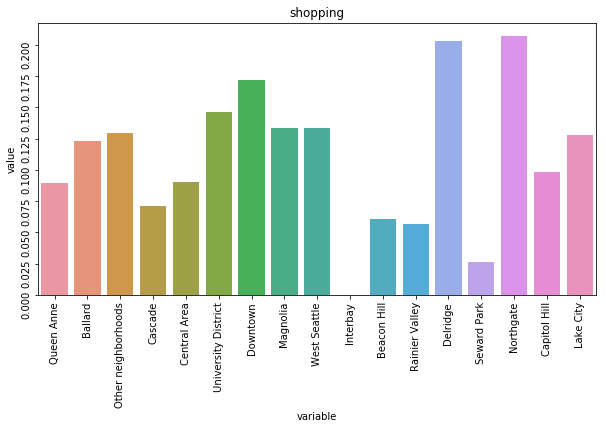

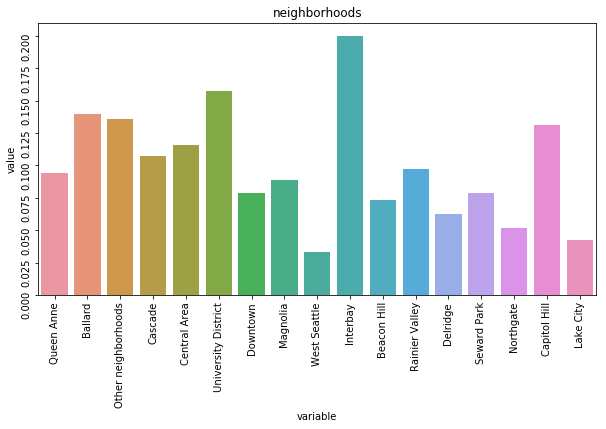

In [153]:
for adj in list(location_final['noun'].unique()):
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    sns.barplot(x=district_melt[district_melt.noun == adj]['variable'], y=district_melt[district_melt['noun'] == adj]['value'])
    ax.tick_params(labelrotation=90)
    plt.title(adj)

In [178]:
lis = lis.drop(columns = lis.columns[lis.columns.str.contains('tokenized')])

## Make dummie variables from amenitis column

In [155]:
lis.amenities

0       {TV,"Cable TV",Internet,"Wireless Internet","A...
1       {TV,Internet,"Wireless Internet",Kitchen,"Free...
2       {TV,"Cable TV",Internet,"Wireless Internet","A...
3       {Internet,"Wireless Internet",Kitchen,"Indoor ...
4       {TV,"Cable TV",Internet,"Wireless Internet",Ki...
                              ...                        
3813    {TV,"Cable TV",Internet,"Wireless Internet","A...
3814    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
3815    {"Cable TV","Wireless Internet",Kitchen,"Free ...
3816    {TV,"Wireless Internet",Kitchen,"Free Parking ...
3817    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, Length: 3818, dtype: object

In [156]:
tokenized_amenities = [word_tokenize(i) for i in lis.amenities.fillna('')]

In [157]:
amenities_list = []
for i in tokenized_amenities:
    amenities_list.extend(list(set(i)))

In [285]:
#lis = lis.drop(columns = lis.columns[lis.columns.str.contains('amenities_')])
#lis.amenities = listings.amenities

In [286]:
dummie_cols = list(set(amenities_list))
for rm in ["''","(",")",",","/", "``","for", "in","live", "on", "pet", "this", "{", "}", "s", "Other", "Hair", "Air", "24-Hour", "Fire", "Free", "Smoke", "Indoor", "Suitable", "First", "Premises", "Hot", "Carbon", "Card", "Bedroom", "Building", "Laptop", "Intercom", "Accessible", "Friendly", "Wireless", "property"]:
    dummie_cols.remove(rm)


In [287]:
for col in dummie_cols:
    lis['amenities_' + col] = lis.amenities.str.contains(col)

In [288]:
dummie_cols

['Dryer',
 'Fireplace',
 'Conditioning',
 'Parking',
 'Iron',
 'Essentials',
 'Cat',
 'Kit',
 'Door',
 'Internet',
 'Buzzer/Wireless',
 'Pets',
 'TV',
 'Extinguisher',
 'Elevator',
 'Allowed',
 'Smoking',
 'Safety',
 'Dog',
 'Tub',
 'Workspace',
 'Lock',
 'Cable',
 'Washer',
 'Heating',
 'Doorman',
 'Pool',
 'Check-in',
 'Hangers',
 'Breakfast',
 'Shampoo',
 'Monoxide',
 'Gym',
 'Kitchen',
 'Family/Kid',
 'Events',
 'Aid',
 'Wheelchair',
 'Detector']

Make sure that newly created columns are not linearly dependent

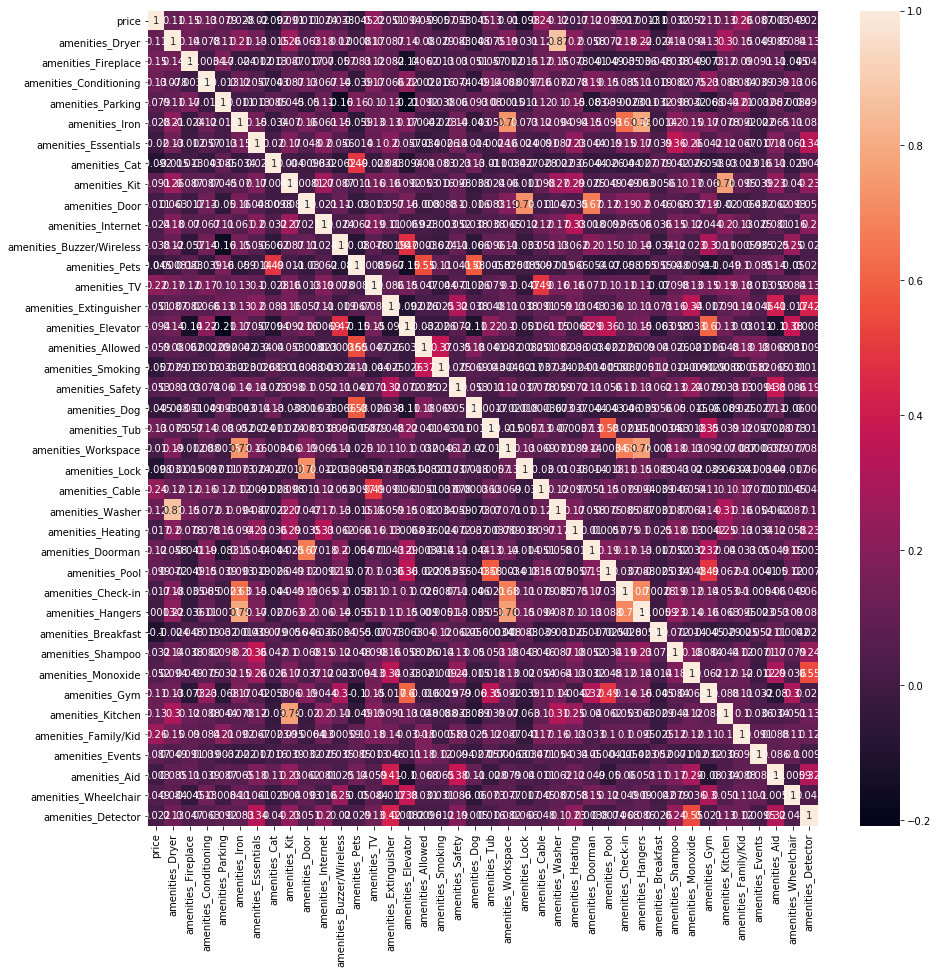

In [326]:
fig = plt.subplots(1,1, figsize= (15,15))
sns.heatmap(data = lis.loc[:,lis.columns.str.contains('amenities') | lis.columns.str.contains('price')].corr(), annot = True);

After creating dummies for most of the str columns, we can drop all remeianing columns, which have too many unique values

In [290]:
def drop_col_too_many(df):
    """
    Drop columns, which have too many unique values
    """
    #df = df.drop(columns = df.columns[lis.nunique()==1])
    #for col in df.columns:
    #    if df[col].nunique()==len(df) | ((df[col].dtypes=='object') & ((df[col].nunique()/len(df)) > 0.3)):
    #        print(col)
    #        df = df.drop(columns = col)
    df = df.drop(columns = lis.columns[lis.nunique()==len(lis)])
    df = df.drop(columns = lis.columns[(lis.dtypes=='object') & ((lis.nunique()/len(lis)) > 0.3)])
    return df
lis = drop_col_too_many(lis)

## Boxplotof price per categorical variable

**Findings**
I tried to find features, which can describe different prices the best. First I looked at categorical features, which are not represented as numbers. These in clude the neighbourhood, property_type, room_type & bed_type
* **property type** In general the property has a price tendencies, but almost all property types have very expensive exceptions. Hence searching for a specific type is not a a price guaranty
    * As expected dorms are by far the cheapest 
    * Lofts, Townhouses, Boats and Condominium are the most expensive
    * Cheap, but more private are campers, bungalows, cabins and tents
    * apertments and houses range in the middle, but they have some very expensive exceptions
    
* **neighbourhood** 
    * Downtown, Magnolia and Queen Hill are most expensive
    * Beacon, University District and Lake City are the cheapest
    
* **room type** 
    * As expected entire home > private room > shared room 
    


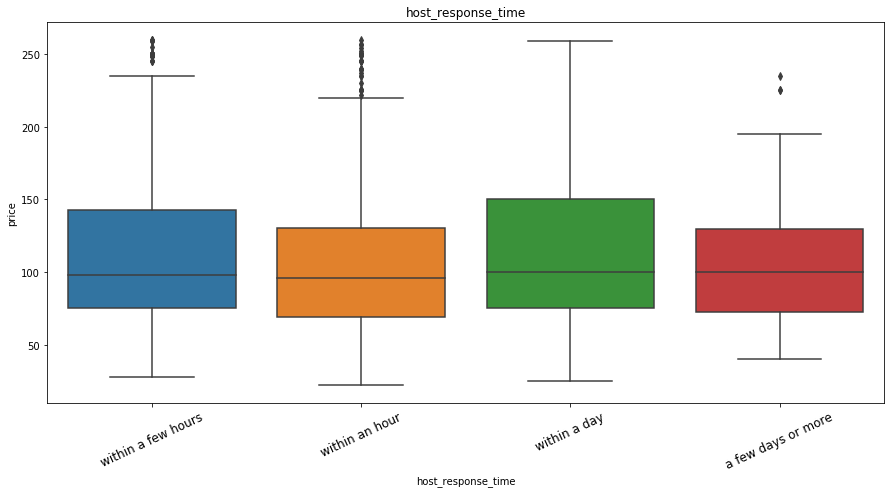

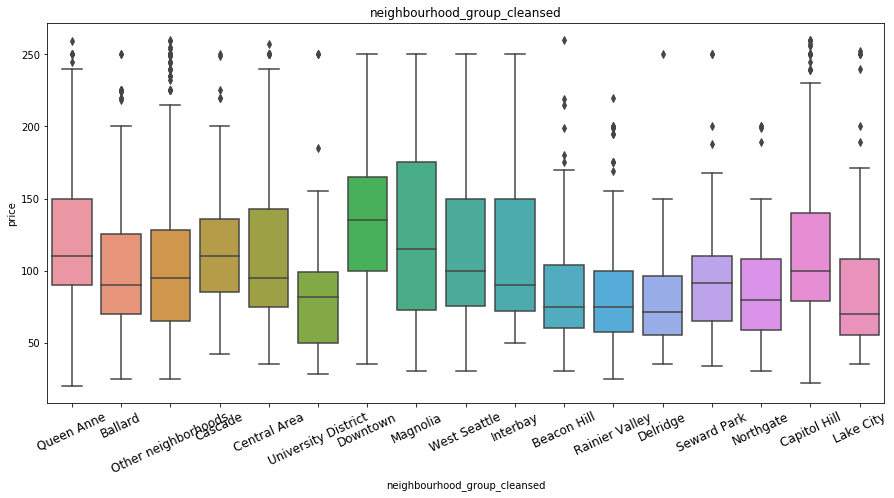

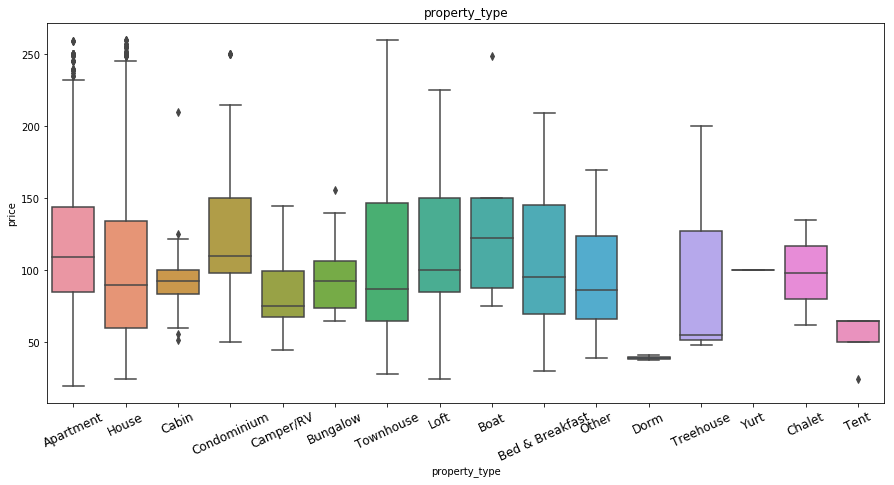

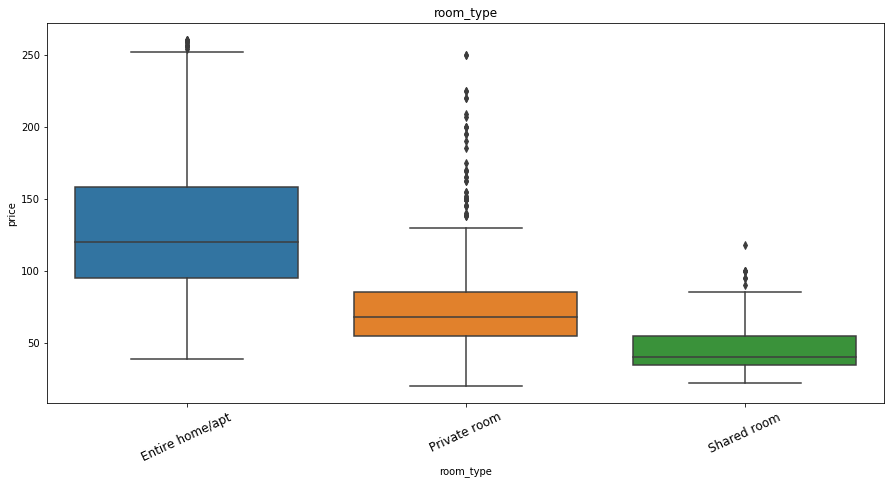

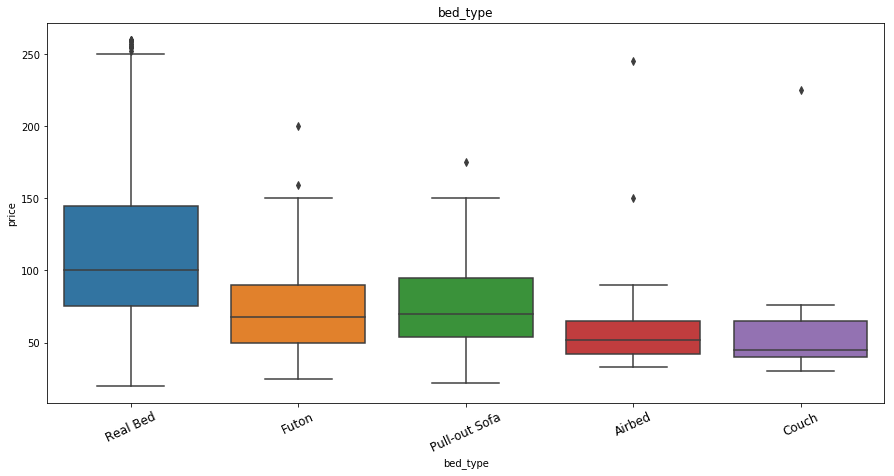

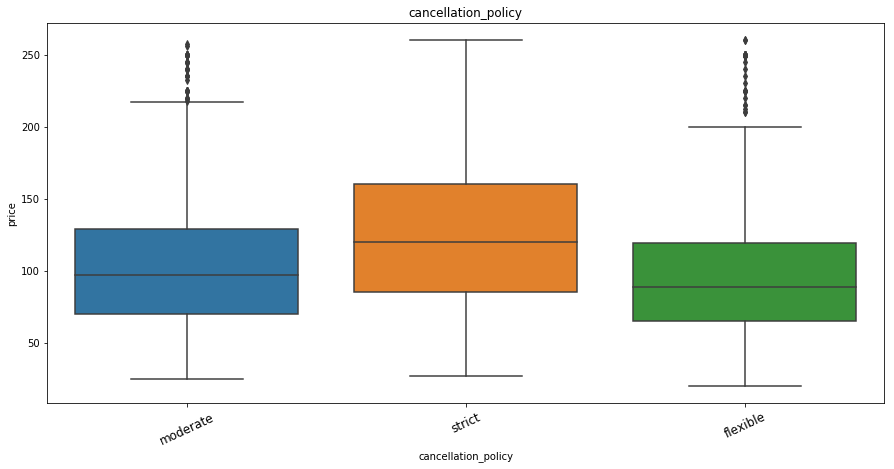

In [291]:
for col in lis.columns[lis.dtypes == "object"]:
    fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
    sns.boxplot(x=col, y="price", data=lis_drop_outlier)
    plt.xticks(rotation=25, size=12)
    plt.title(col)
    plt.savefig('pictures/boxplot_' + col)

# Modelling Linear Regression

Check

## Linear regression

In [350]:
def clean_fit_linear_mod(df, response_col, drop_outliers = False, test_size=.3, rand_state=42, lin_model = "Ridge"):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    function creates dummie columns from object columns
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''

    X = pd.get_dummies(df, columns = df.columns[df.dtypes == "object"], drop_first=True , dummy_na=False)
    X = X.drop(columns = response_col)
    Y = df[response_col]    
    if X.isna().any().any():
        print('There are NA values in X!')
        return

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = rand_state)
    
    if drop_outliers:
        Q1 = Y_train.quantile(0.25)
        Q3 = Y_train.quantile(0.75)
        IQR = Q3-Q1
        Lower_Whisker = Q1 - 1.5*IQR
        Upper_Whisker = Q3 + 1.5*IQR
        Y_train = Y_train[Y_train < Upper_Whisker]
        X_train = X_train.loc[Y_train.index]
        
    
    if lin_model == 'Ridge':
        lm = RidgeCV(normalize = True, alphas=[1e-3, 1e-2, 1e-1, 1], store_cv_values = True)
    elif lin_model == 'Lin':
        lm = LinearRegression(normalize = True)
    else:
        print('No regression type provided')
        return
    

        
    lm.fit(X_train, Y_train)
    Y_test_predict = lm.predict(X_test)
    Y_train_predict = lm.predict(X_train)
    
    test_score = r2_score(Y_test, Y_test_predict)
    train_score = r2_score(Y_train, Y_train_predict)
    
    print('Model:', lin_model)
    print('Trained without?', drop_outliers)
    print('train_scrore', round(test_score,2))
    print('test_scrore', round(test_score,2))
    print('\n')
    
    return test_score, train_score, lm, X_train, X_test, Y_train, Y_test, Y_test_predict



# Evaluation Linear Regression

*** Can I predict the price per listing?**  
I can predict the price with an R2 of 0.62, which is not satisfying
Ridge regression tends to perform slightly better than linear regression
CatBoosed showed no improvement

**Make sure that no linear dependency is given**

In [343]:
test_cols = ['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'bed_type',
       'square_feet', 'price', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_location', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'aprtmnt_adj_private',
       'aprtmnt_adj_large', 'aprtmnt_adj_queen', 'aprtmnt_adj_comfortable',
       'aprtmnt_adj_quiet', 'aprtmnt_adj_spacious', 'aprtmnt_adj_new', 'aprtmnt_adj_own',
       'aprtmnt_adj_modern', 'aprtmnt_adj_beautiful', 'aprtmnt_adj_main',
       'aprtmnt_adj_small', 'aprtmnt_adj_open', 'aprtmnt_adj_entire',
       'aprtmnt_adj_clean', 'aprtmnt_adj_free', 'amenities_Fireplace', 'amenities_Conditioning',
       'amenities_Parking',
       'amenities_Cat', 
       'amenities_Internet', 'amenities_Buzzer/Wireless', 'amenities_Pets',
       'amenities_TV', 'amenities_Extinguisher', 'amenities_Elevator', 'amenities_Smoking',
       'amenities_Dog', 'amenities_Tub', 'amenities_Workspace',  'amenities_Washer', 'amenities_Doorman', 'amenities_Pool',
       'amenities_Breakfast',
       'amenities_Shampoo', 'amenities_Gym',
        'amenities_Family/Kid', 'amenities_Events',
      'amenities_Wheelchair', 'amenities_Detector']

In [331]:
corr_matrix = lis.corr()
for col in corr_matrix.columns:
    if len(corr_matrix[(corr_matrix[col]>0.9) & (corr_matrix.index !=col)].index) >0:
        print(len(corr_matrix[(corr_matrix[col]>0.9) & (corr_matrix.index !=col)].index))

### Try linear regression with some variations

Ridge regression wins

In [351]:
print('All columns, linear regression')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis, 'price', drop_outliers = False, lin_model = "Lin")#.drop(columns = drop_columns_catboost)
print('All columns, linear regression dropped outliers')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis, 'price', drop_outliers = True, lin_model = "Lin")#.drop(columns = drop_columns_catboost)
print('All columns, Ridge regression')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis, 'price', drop_outliers = False, lin_model = "Ridge")#.drop(columns = drop_columns_catboost)


lis_no_aprtmnt = lis.drop(columns = lis.columns[lis.columns.str.contains('aprtmnt_adj')])
print('without apartment adjective columns, linear regression')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis_no_aprtmnt, 'price', drop_outliers = False, lin_model = "Lin")
print('without apartment adjective columns, linear regression, dropped outlier')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis_no_aprtmnt, 'price', drop_outliers = False, lin_model = "Ridge")#.drop(columns = drop_columns_catboost)
print('without apartment adjective columns, ridge regression')


lis_no_amenities_ = lis.drop(columns = lis.columns[lis.columns.str.contains('amenities_')])
print('without amenitiescolumns, linear regression')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis_no_amenities_, 'price', drop_outliers = False, lin_model = "Lin")
print('without amenitiescolumns, Ridge regression')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis_no_amenities_, 'price', drop_outliers = False, lin_model = "Ridge")#.drop(columns = drop_columns_catboost)

lis_without_additional = lis.drop(columns = list(lis.columns[lis.columns.str.contains('amenities_') | lis.columns.str.contains('aprtmnt_adj')]))
print('without apartment adjective, without amenities columns, linear regression')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis_without_additional, 'price', drop_outliers = False, lin_model = "Lin")
print('without apartment adjective, without amenities columns, ridge regression')
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, Y_test_predict = clean_fit_linear_mod(lis_without_additional, 'price', drop_outliers = False, lin_model = "Ridge")#.drop(columns = drop_columns_catboost)

print('Linear regression with manually selected columns')
test_score, train_score, lm_model, X_train, X_test, Y_train, Y_test, Y_test_predict = clean_fit_linear_mod(lis.loc[:,test_cols], 'price', drop_outliers = False, lin_model = "Lin")#.drop(columns = drop_columns_catboost)

All columns, linear regression
Model: Lin
Trained without? False
train_scrore -1.244738208684438e+21
test_scrore -1.244738208684438e+21


All columns, linear regression dropped outliers
Model: Lin
Trained without? True
train_scrore -7.787836163959531e+21
test_scrore -7.787836163959531e+21


All columns, Ridge regression
Model: Ridge
Trained without? False
train_scrore 0.62
test_scrore 0.62


without apartment adjective columns, linear regression
Model: Lin
Trained without? False
train_scrore -2.4881650793745786e+21
test_scrore -2.4881650793745786e+21


without apartment adjective columns, linear regression, dropped outlier
Model: Ridge
Trained without? False
train_scrore 0.61
test_scrore 0.61


without apartment adjective columns, ridge regression
without amenitiescolumns, linear regression
Model: Lin
Trained without? False
train_scrore 0.61
test_scrore 0.61


without amenitiescolumns, Ridge regression
Model: Ridge
Trained without? False
train_scrore 0.61
test_scrore 0.61


without apa

The prediction seems to struggle with very expensive listings (which are underpredicted)

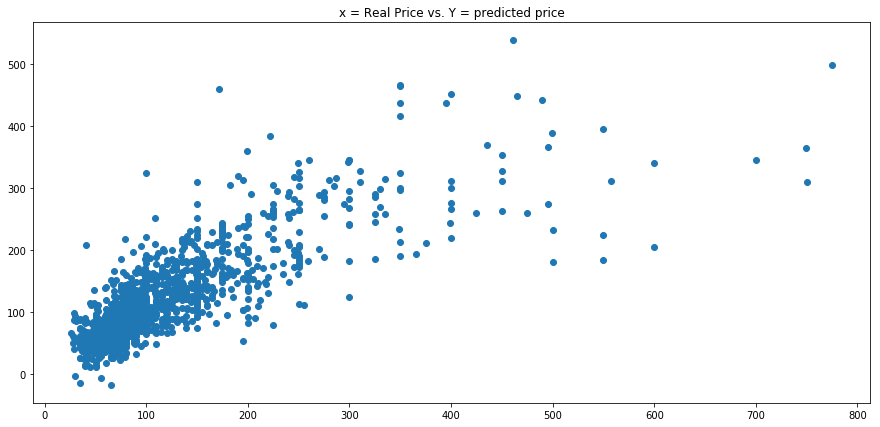

In [354]:
fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
plt.scatter(x = Y_test, y = Y_test_predict)
plt.title('x = Real Price vs. Y = predicted price')
plt.savefig('pictures/prediction_Ridge')

Least important features in terms of linearity factor


coeff_names  coeff_vals
5                                   is_location_exact    4.591824
66          neighbourhood_group_cleansed_Central Area    4.570786
56                                   amenities_Events    3.904478
53                                  amenities_Shampoo    3.665268
39                             amenities_Conditioning    3.369029
42                          amenities_Buzzer/Wireless    3.168100
36                                  aprtmnt_adj_clean    3.052487
28                                    aprtmnt_adj_new    2.884720
18                      require_guest_profile_picture    2.816102
32                                   aprtmnt_adj_main    2.757383
23                                  aprtmnt_adj_large    2.665516
17                                   instant_bookable    2.435384
78          neighbourhood_group_cleansed_West Seattle    2.351502
22                                aprtmnt_adj_private    2.326527
11                                    guests_included    2.285139
31                              aprtmnt_adj_beautiful    2.120332
35                                 aprtmnt_adj_entire    1.779732
16                             review_scores_location    1.723262
41                                      amenities_Cat    1.614537
57                               amenities_Wheelchair    1.202039
10                                       cleaning_fee    0.414087
15                               review_scores_rating    0.347676
26                                  aprtmnt_adj_quiet    0.343715
37                                   aprtmnt_adj_free    0.157887
12                                       extra_people    0.131324
9                                         square_feet    0.012233
13                                     minimum_nights   -0.015248
2                                 host_listings_count   -0.016923
14                                  number_of_reviews   -0.031277
20                     calculated_host_listings_count   -0.084049
25                            aprtmnt_adj_comfortable   -0.243763
58                                 amenities_Detector   -1.151737
4                              host_identity_verified   -1.177485
45                             amenities_Extinguisher   -1.231130
73   neighbourhood_group_cleansed_Other neighborhoods   -1.234541
55                               amenities_Family/Kid   -1.388983
69              neighbourhood_group_cleansed_Interbay   -1.998921
33                                  aprtmnt_adj_small   -2.408901
21                                  reviews_per_month   -2.607757
43                                     amenities_Pets   -2.783150
60                    host_response_time_within a day   -2.803509
40                                  amenities_Parking   -2.855649
102                        cancellation_policy_strict   -2.895934
27                               aprtmnt_adj_spacious   -4.014294
0                                  host_response_rate   -4.036958
77   neighbourhood_group_cleansed_University District   -4.306740
62                  host_response_time_within an hour   -4.446707
101                      cancellation_policy_moderate   -4.447772
50                                   amenities_Washer   -4.575553
52                                     amenities_Pool   -4.926676

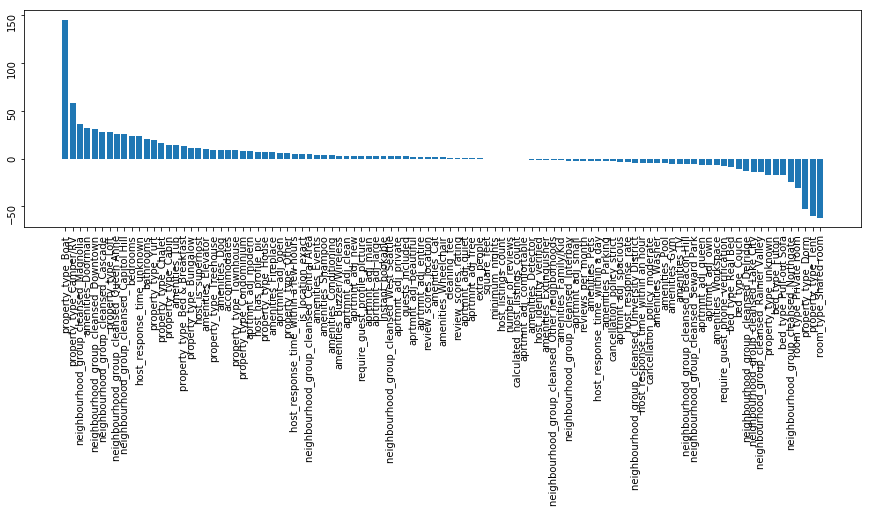

In [333]:
lin_coeff = pd.DataFrame({'coeff_names':X_train.columns, 'coeff_vals':lm_model.coef_}).sort_values(by = 'coeff_vals', ascending = False)
fig, ax = plt.subplots(1,1, figsize = (15,4))
plt.bar(lin_coeff[lin_coeff.coeff_vals != 0].coeff_names, lin_coeff[lin_coeff.coeff_vals != 0].coeff_vals)
ax.tick_params(labelrotation=90);
print('Least important features in terms of linearity factor')
lin_coeff[np.abs(lin_coeff.coeff_vals) < 5]

# Modelling Catboost

catboost can handle categorical variables without encoding

In [334]:
def fit_train_catboost(df, response_col, test_size=.3, rand_state=42):
    # initialize data


    cat_col = df.select_dtypes(include = ['object']).columns
    fill_na = [lambda col: col.fillna("unknown")]
    df[cat_col] = df[cat_col].apply(fill_na, axis = 0)


    X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns = ['price']), df['price'], test_size = test_size, random_state=rand_state)


    train_data = X_train
    train_label = Y_train
    test_data = X_test


    # initialize Pool
    train_pool = Pool(train_data, 
                  train_label, 
                  cat_features=train_data.select_dtypes(include = ['object', 'bool']).columns)
    test_pool = Pool(test_data, 
                 cat_features=test_data.select_dtypes(include = ['object', 'bool']).columns) 

    # specify the training parameters 
    model = CatBoostRegressor(iterations=200, 
                          depth=5, 
                          learning_rate=0.6, 
                          loss_function='RMSE',
                             silent=True)
    #train the model
    model.fit(train_pool)
    # make the prediction using the resulting model
    Y_test_predict = model.predict(test_pool)
    Y_train_predict = model.predict(train_pool)
    feature_imp = pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': train_data.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
    
    test_score = r2_score(Y_test, Y_test_predict)
    train_score = r2_score(Y_train, Y_train_predict)
    print('train_scrore', round(test_score,2))
    print('test_scrore', round(test_score,2))
    
    return test_score, train_score, model, X_train, X_test, Y_train, Y_test, feature_imp

def plot_feature_importance(importance, model_type):
    

    
    #Sort the DataFrame in order decreasing feature importance
    importance.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,15))
    #Plot Searborn bar chart
    sns.barplot(x=importance['feature_importance'], y=importance['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Evaluation CatBoost

In [335]:
test_score, train_score, model, X_train, X_test, Y_train, Y_test, feature_imp = fit_train_catboost(lis, 'price')

train_scrore 0.62
test_scrore 0.62


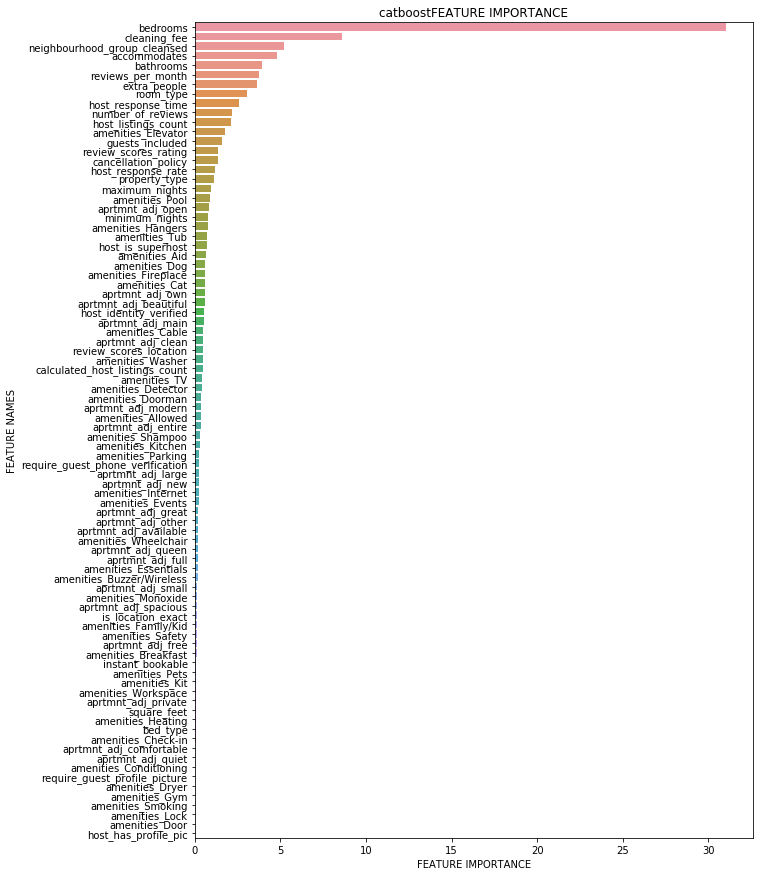

In [336]:
plot_feature_importance(feature_imp[feature_imp.feature_importance >0],'catboost')

In [337]:
list(feature_imp[feature_imp.feature_importance <0.05].feature_names)

['bed_type',
 'amenities_Check-in',
 'aprtmnt_adj_comfortable',
 'aprtmnt_adj_quiet',
 'amenities_Conditioning',
 'require_guest_profile_picture',
 'amenities_Dryer',
 'amenities_Gym',
 'amenities_Smoking',
 'amenities_Lock',
 'amenities_Door',
 'host_has_profile_pic',
 'amenities_Iron',
 'amenities_Extinguisher']

Just some additional insights